# Analysis of the AirBnB listings in New York City

In this notebook we will analyse the listings on the AirBnB website in New York City. We will focus in particular on:

• Analyzing the data quantitatively per neighborhood, borough, amenities, etc, showing how many listings are in each of category and also the average price

• Remove the columns in the dataframe that are not useful for our study (e.g. the listing url)

• Cleaning the data if needed, removing NaNs

• Studying the correlation between the different features and the price of the listing

• Add a column for each amenity, indicating with a boolean variable whether a specific listing has that amenity (1) or not (0)

• Analyzing the description of the listings, highlighting the relationships between specific keywords and the price/neighboorhood/size of the listing. One example is the word "cozy": what are the average size and price when such word appears in the description? Same goes for the word "luxurious"/"luxury"

• Plot some interesting findings

• In another notbook, we will use some machine learning models to estimate the price of a listing given its features (location, neighboorhood, amenities, size, etc)

## Importing and cleaning the data

### Import the data and remove unuseful columns

In [1]:
#Import the useful stuff
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
from scipy import optimize
from datetime import datetime, date, timedelta
from scipy.stats.mstats import gmean

import folium
import fnmatch
import re
import copy
from collections import Counter
import nltk.corpus
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

In [290]:
#Useful configurations
pd.set_option("display.max_rows", 100, "display.max_columns", None)

In [3]:
#Read the dataframe and use ID column as index
df = pd.read_csv('listings_nyc.csv', index_col='id')
df.index.name = None

In [4]:
#Which are the columns in the dataframe?
df.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated',

Let's remove the columns we don't need

In [5]:
df.drop(['scrape_id', 'last_scraped','picture_url','host_url','host_thumbnail_url', 
         'host_picture_url','host_verifications','host_has_profile_pic', 'host_identity_verified',  
         'neighbourhood','calendar_updated','last_review','has_availability','calendar_last_scraped', 
         'instant_bookable','calculated_host_listings_count','calculated_host_listings_count_entire_homes', 
         'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
         'neighborhood_overview','license','availability_30', 'availability_60', 'availability_90', 'minimum_nights',
         'maximum_nights','minimum_minimum_nights','maximum_minimum_nights', 'minimum_maximum_nights',
         'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','availability_365',
         'host_name','host_about','host_response_time','host_response_rate','host_acceptance_rate'],inplace = True, axis = 1)

We have eliminated the column 'neighbourhood' because 'neighbourhood_cleansed' is the column that contains the actual neighborhood in the correct format.

Let's now take a look at the dataframe

In [6]:
df.head(5)

listing_url  \
2595  https://www.airbnb.com/rooms/2595   
3831  https://www.airbnb.com/rooms/3831   
5121  https://www.airbnb.com/rooms/5121   
5136  https://www.airbnb.com/rooms/5136   
5178  https://www.airbnb.com/rooms/5178   

                                                   name  \
2595                              Skylit Midtown Castle   
3831  Whole flr w/private bdrm, bath & kitchen(pls r...   
5121                                    BlissArtsSpace!   
5136           Spacious Brooklyn Duplex, Patio + Garden   
5178                   Large Furnished Room Near B'way　   

                                            description  host_id  host_since  \
2595  Beautiful, spacious skylit studio in the heart...     2845  2008-09-09   
3831  Enjoy 500 s.f. top floor in 1899 brownstone, w...     4869  2008-12-07   
5121  <b>The space</b><br />HELLO EVERYONE AND THANK...     7356  2009-02-03   
5136  We welcome you to stay in our lovely 2 br dupl...     7378  2009-02-03   
5178  Please don’t expect the luxury here just a bas...     8967  2009-03-03   

                          host_location host_is_superhost  host_neighbourhood  \
2595  New York, New York, United States                 f             Midtown   
3831  New York, New York, United States                 f        Clinton Hill   
5121  New York, New York, United States                 f  Bedford-Stuyvesant   
5136  New York, New York, United States                 f   Greenwood Heights   
5178  New York, New York, United States                 f      Hell's Kitchen   

      host_listings_count  host_total_listings_count neighbourhood_cleansed  \
2595                  6.0                        6.0                Midtown   
3831                  1.0                        1.0     Bedford-Stuyvesant   
5121                  1.0                        1.0     Bedford-Stuyvesant   
5136                  1.0                        1.0            Sunset Park   
5178                  1.0                        1.0                Midtown   

     neighbourhood_group_cleansed  latitude  longitude  \
2595                    Manhattan  40.75356  -73.98559   
3831                     Brooklyn  40.68494  -73.95765   
5121                     Brooklyn  40.68535  -73.95512   
5136                     Brooklyn  40.66265  -73.99454   
5178                    Manhattan  40.76457  -73.98317   

                  property_type        room_type  accommodates  bathrooms  \
2595           Entire apartment  Entire home/apt             2        NaN   
3831         Entire guest suite  Entire home/apt             3        NaN   
5121  Private room in apartment     Private room             2        NaN   
5136           Entire apartment  Entire home/apt             4        NaN   
5178  Private room in apartment     Private room             2        NaN   

     bathrooms_text  bedrooms  beds  \
2595         1 bath       NaN   1.0   
3831         1 bath       1.0   3.0   
5121            NaN       1.0   1.0   
5136      1.5 baths       2.0   2.0   
5178         1 bath       1.0   1.0   

                                              amenities    price  \
2595  ["Refrigerator", "Essentials", "Cleaning befor...  $150.00   
3831  ["Bathtub", "Smoke alarm", "Dishes and silverw...   $76.00   
5121  ["Kitchen", "Heating", "Wifi", "Long term stay...   $60.00   
5136  ["Kitchen", "Cable TV", "TV", "Carbon monoxide...  $175.00   
5178  ["Heating", "Bed linens", "TV", "Iron", "Free ...   $79.00   

      number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
2595                 48                      0                       0   
3831                396                     80                       2   
5121                 50                      0                       0   
5136                  1                      0                       0   
5178                474                      1                       0   

     first_review  review_scores_rating  review_scores_accuracy  \
259

In [7]:
df.describe(include='all')

listing_url  \
count                                   36905   
unique                                  36905   
top     https://www.airbnb.com/rooms/47826512   
freq                                        1   
mean                                      NaN   
std                                       NaN   
min                                       NaN   
25%                                       NaN   
50%                                       NaN   
75%                                       NaN   
max                                       NaN   

                                              name  \
count                                        36892   
unique                                       35651   
top     Well-kept apartment home | 1BR in New York   
freq                                            41   
mean                                           NaN   
std                                            NaN   
min                                            NaN   
25%                                            NaN   
50%                                            NaN   
75%                                            NaN   
max                                            NaN   

                                              description       host_id  \
count                                               35637  3.690500e+04   
unique                                              33507           NaN   
top     Stay for 31+ nights (minimum nights and rates ...           NaN   
freq                                                   55           NaN   
mean                                                  NaN  9.847262e+07   
std                                                   NaN  1.145377e+08   
min                                                   NaN  2.438000e+03   
25%                                                   NaN  1.010236e+07   
50%                                                   NaN  4.267652e+07   
75%                                                   NaN  1.613001e+08   
max                                                   NaN  3.958177e+08   

        host_since                      host_location host_is_superhost  \
count        35637                              35549             35637   
unique        4035                               1393                 2   
top     2016-12-16  New York, New York, United States                 f   
freq           278                              22099             29301   
mean           NaN                                NaN               NaN   
std            NaN                                NaN               NaN   
min            NaN                                NaN               NaN   
25%            NaN                                NaN               NaN   
50%            NaN                                NaN               NaN   
75%            NaN                                NaN               NaN   
max            NaN                                NaN               NaN   

       host_neighbourhood  host_listings_count  host_total_listings_count  \
count               29280         35637.000000               35637.000000   
unique                415                  NaN                        NaN   
top          Williamsburg                  NaN                        NaN   
freq                 2114                  NaN                        NaN   
mean                  NaN            28.464293                  28.464293   
std                   NaN           181.069747                 181.069747   
min                   NaN             0.000000                   0.000000   
25%                   NaN             1.000000                   1.000000   
50%                   NaN             1.000000                   1.000000   
75%                   NaN             3.000000                   3.000000   
max                   NaN          2844.000000                2844.000000   

       neighbourhood_cleansed neighbourhood_group_cleansed      latit

### Clean the data

#### Replacing missing data

The columns 'bathroom' and 'bedrooms' seem to have a lot of NaNs. Let's confirm this:

In [8]:
print(np.count_nonzero(np.isnan(df['bathrooms']))/len(df.bathrooms)*100)
print(np.count_nonzero(np.isnan(df['bedrooms']))/len(df.bathrooms)*100)

100.0
9.955290611028316


100% of the column 'bathrooms' contains a NaN. However, the column 'bathrooms_text' contains the correct values for the bathrooms.

Note that a 'half bathroom' means usually a toilet + sink

In [9]:
print(df.bathrooms_text.unique())

['1 bath' nan '1.5 baths' '1 shared bath' '1 private bath' '2 baths'
 '1.5 shared baths' '3 baths' 'Half-bath' '2 shared baths' '2.5 baths'
 '5 baths' '0 baths' '0 shared baths' 'Private half-bath'
 'Shared half-bath' '4.5 baths' '5.5 baths' '2.5 shared baths' '3.5 baths'
 '15.5 baths' '6 baths' '4 baths' '3 shared baths' '4 shared baths'
 '3.5 shared baths' '6 shared baths' '6.5 shared baths' '4.5 shared baths'
 '7.5 baths' '5.5 shared baths' '5 shared baths' '6.5 baths' '8 baths'
 '7 baths' '7 shared baths' '9.5 baths']


The listings with 0 baths do have one, but the hosts have not indicated it correctly on the listing. Let's correct it. Let's do the same for the NaN baths.

Let's also change extract the number from 'bathrooms_text' and add it to 'bathrooms', then drop 'bathrooms_text'. We will obtain a column with the numeric value of the number of bathrooms


In [10]:
df.loc[df.bathrooms_text.isna(),'bathrooms_text'] = '1'
for string in ['0 baths','0 shared baths','0 shared baths','Shared half-bath','Private half-bath','Half-bath']:
    df.loc[df.bathrooms_text == string,'bathrooms_text'] = '1'

df.loc[:,'bathrooms'] = [float(s.split()[0]) for s in df.loc[:,'bathrooms_text']]

df.drop('bathrooms_text',axis = 1,inplace = True)

Let's check the data types. Does the data type match the column values?

In [11]:
print(df.dtypes)

listing_url                      object
name                             object
description                      object
host_id                           int64
host_since                       object
host_location                    object
host_is_superhost                object
host_neighbourhood               object
host_listings_count             float64
host_total_listings_count       float64
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
amenities                        object
price                            object
number_of_reviews                 int64
number_of_reviews_ltm             int64
number_of_reviews_l30d            int64


We notice that 'host_since' and 'first_review' are 'object', but they should be dates. Let's correct that

In [12]:
for col in ['host_since','first_review']:
    df.loc[:,col] = pd.to_datetime(df.loc[:,col])

The column 'host_is_superhost' has values 'f' or 't'. Let's change it to '0' or '1'

In [13]:
df.loc[df['host_is_superhost'] == 't','host_is_superhost'] = 1
df.loc[df['host_is_superhost'] == 'f','host_is_superhost'] = 0    

The price is in 'object' format. Let's change it to a float

In [14]:
df.price = df.price.str.replace('$','').str.replace(',','')
df.loc[:,'price'] = pd.to_numeric(df.price)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


Let's now check how many missing values are in each column and let's deal with them. For each column, we will choose a different solution. For some of them we will replace the missing values with the minimum, for other ones with the average.

Let's start then by seeing the percentage of null values for each column.

In [15]:
df.isnull().sum().sort_values(ascending = False)/len(df.index)*100

review_scores_location          28.302398
review_scores_value             28.302398
review_scores_checkin           28.299688
review_scores_accuracy          28.272592
review_scores_communication     28.264463
review_scores_cleanliness       28.242786
review_scores_rating            28.204850
first_review                    26.337895
reviews_per_month               26.337895
host_neighbourhood              20.661157
bedrooms                         9.955291
host_location                    3.674299
host_total_listings_count        3.435849
host_listings_count              3.435849
host_is_superhost                3.435849
host_since                       3.435849
description                      3.435849
beds                             1.568893
name                             0.035226
number_of_reviews                0.000000
number_of_reviews_l30d           0.000000
number_of_reviews_ltm            0.000000
listing_url                      0.000000
price                            0

We notice that many columns are missing some values. Let's fix this:

• For most of the numerical columns, we will replace the quantity with the average of that column. This applies to all the "review" columns, to

• For the columns that contain dates, we will also apply the mean. This applies to columns "first_review" and "host_since"

• For the "host_is_superhost" column, we will apply a value of 0

• We assign to the empty values in the "bedrooms" column a value of 1, since there is at least 1 bedroom, and using the mean could lead to large errors. Another possibility is to drop the rows for which there is no data of the amount of bedrooms, but that would mean losing around 10% of the listings.

• For the "description" column, we will add a "No description" value. For the "name" column we adopt the same strategy and enter the value "No name"

• For the "host_neighbourhood" column, we will take the neighborhood of the listing

In [16]:
review_cols = ['review_scores_value', 'review_scores_location', 'review_scores_checkin', 'review_scores_accuracy',
               'review_scores_communication', 'review_scores_cleanliness', 'review_scores_rating','reviews_per_month']
mean_cols = review_cols.append('beds')

for col in review_cols:
    df.loc[:,col].fillna(df.loc[:,col].mean(),inplace = True)

df['bedrooms'].fillna(1,inplace = True)
df['host_is_superhost'].fillna(0,inplace = True)
df['description'].fillna('No description',inplace = True)
df['name'].fillna('No name',inplace = True)
df['first_review'].fillna(df.first_review.mean(),inplace = True)
#host columns
df['host_neighbourhood'].fillna(df.neighbourhood_cleansed,inplace = True)
df['host_location'].fillna(df.host_location.describe().top,inplace = True)
df['host_since'].fillna(df.host_since.mean(),inplace = True)
df['host_since'].fillna(df.host_since.mean(),inplace = True)
df['host_listings_count'].fillna(int(df.host_listings_count.mean()),inplace = True)
df['host_total_listings_count'].fillna(int(df.host_total_listings_count.mean()),inplace = True)


#### Removal of outliers

Let's now plot a boxplot for the 5 boroughs of NYC and their price. From the boxplots we will learn more about the distribution of the price in each borough and also we will spot the outliers

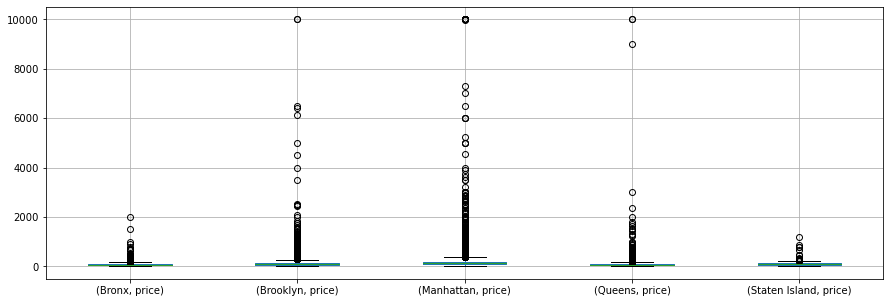

In [17]:
boroughs_prices = df.groupby('neighbourhood_group_cleansed')
boroughs_prices.boxplot(column = 'price', subplots = False, figsize = (15,5))
plt.show()

We notice that there is a very large amount of outliers. Let's see the plot again but limiting the y-axis to 1000$.

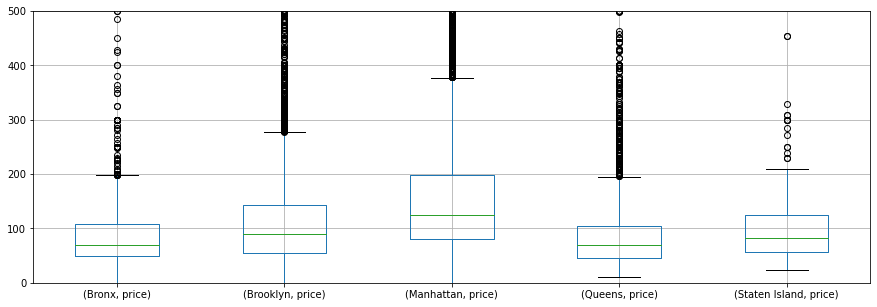

In [29]:
boroughs_prices = df.groupby('neighbourhood_group_cleansed')
boroughs_prices.boxplot(column = 'price', subplots = False, figsize = (15,5))
plt.ylim(0,1000)
plt.show()

We notice that indeed limiting the prices up to 1000\\$ seems a good choice, although there are still many outliers above 200$. Let's drop all the listings with a price higher than 1000\\$.

In [30]:
df.drop(index = df[df.price > 1000].index, inplace = True)

#### Amenities of the listings

Let's create a different column for each amenity, with a boolean value indicating whether that amenity is present or not.
First, let's start by creating a set of all the amenities

In [14]:
df.loc[:,'amenities'] = df.loc[:,'amenities'].str.lower()
df['amenities'] = df['amenities'].str.replace(
    '$','').str.replace('cable tv','tv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
amenities = set()
for idx in df.index:
    df.loc[idx,'amenities'] = re.sub('\\\\','',df.loc[idx,'amenities'])
    string_list = [each_string.lower() for each_string in (df.loc[idx,'amenities'].split('"'))]
    #string_list = df.loc[idx,'amenities'].replace('[','').replace(']','').replace('"','').split(', ')
    amenities = amenities.union(set(string_list))
    
amenities.difference_update(set([', ','[',']','[]']))
amenities

{' bosh refrigerator',
 ' hdtv',
 ' hdtv with amazon prime video',
 ' hdtv with amazon prime video, apple tv, chromecast, hbo max, netflix, premium cable, roku',
 ' hdtv with amazon prime video, apple tv, chromecast, hbo max, netflix, roku, premium cable',
 ' hdtv with amazon prime video, apple tv, hbo max, chromecast, netflix, premium cable, roku',
 ' hdtv with amazon prime video, apple tv, hbo max, netflix, premium cable',
 ' hdtv with amazon prime video, apple tv, hbo max, netflix, premium cable, roku, standard cable',
 ' hdtv with amazon prime video, apple tv, hbo max, netflix, premium cable, standard cable',
 ' hdtv with amazon prime video, apple tv, hbo max, netflix, roku',
 ' hdtv with amazon prime video, apple tv, netflix',
 ' hdtv with amazon prime video, apple tv, netflix, hbo max',
 ' hdtv with amazon prime video, chromecast',
 ' hdtv with amazon prime video, chromecast, apple tv, hbo max, netflix, premium cable, roku',
 ' hdtv with amazon prime video, chromecast, netflix, s

From the list of amenities, we see that many are very similar between them and we can group them together, e.g. ' HDTV','HDTV with Amazon Prime Video' means there is a TV. Same for shampoo, etc.

Let's create a sorted dictionary of the words inside the amenities with their frequency and then group together these amenities with a single word.


In [16]:
am_list = list(amenities)
words = []
for am in am_list:
    words.extend(am.split())

#Create a dictionary with all the words in the amenities and sort by most frequent
{k: v for k, v in sorted(Counter(words).items(), key=lambda item: item[1],reverse= True)}

{'with': 171,
 'and': 109,
 'hdtv': 104,
 'soap': 97,
 'body': 93,
 'amazon': 87,
 'prime': 86,
 'netflix,': 83,
 'sound': 76,
 'system': 75,
 'conditioner': 69,
 'video,': 63,
 'stainless': 58,
 'steel': 58,
 'stove': 58,
 'bluetooth': 55,
 'shampoo': 53,
 'refrigerator': 52,
 'u2014': 51,
 'oven': 47,
 'u2013': 47,
 'tv': 44,
 'parking': 43,
 'hbo': 42,
 'cable': 41,
 'premium': 40,
 'standard': 35,
 'paid': 34,
 'premises': 34,
 'clothing': 34,
 'max,': 34,
 'dedicated': 33,
 'storage:': 32,
 'workspace:': 32,
 'cable,': 32,
 'apple': 32,
 'onsite': 29,
 'wifi': 28,
 'gas': 28,
 'aux': 28,
 'roku': 26,
 'tv,': 26,
 'office': 25,
 'per': 25,
 'on': 24,
 'netflix': 23,
 'video': 23,
 'mbps': 23,
 'closet,': 22,
 'restaurant': 22,
 'bar': 21,
 'closet': 20,
 '&': 20,
 'electric': 18,
 'in': 18,
 'roku,': 18,
 'walk-in': 17,
 'desk': 16,
 'chromecast': 15,
 'day': 15,
 'garage': 15,
 'toiletries': 15,
 'chromecast,': 15,
 'off': 14,
 'table,': 14,
 'chair,': 14,
 'game': 14,
 'years': 1

We can use the above frequency list to understand which are the amenities that we can group together with a single word:

In [17]:
df.loc[:,'amenities'].iloc[0]

'["refrigerator", "essentials", "cleaning before checkout", "long term stays allowed", "luggage dropoff allowed", "baking sheet", "dishes and silverware", "kitchen", "keypad", "tv", "heating", "fire extinguisher", "paid parking off premises", "free street parking", "cooking basics", "bathtub", "stove", "ethernet connection", "hot water", "wifi", "hair dryer", "dedicated workspace", "iron", "extra pillows and blankets", "coffee maker", "carbon monoxide alarm", "hangers", "smoke alarm", "oven", "bed linens", "air conditioning"]'

In [18]:
remove_and_add_str = ['tv', 'shampoo','refrigerator','wifi','soap','gym', 'clothing storage',
                      'oven','stove','sound system','breakfast','toiletries','parking','coffee maker','game console',
                      'dedicated workspace','air conditioning','pool','garden','hot tub', 'washer', 'heating','linens',
                     'pillows','books and toys','dryer','onsite restaurant','onsite bar', 'onsite rooftop']
#remove_only.extend(remove_and_add_str)
tmp = copy.deepcopy(amenities)

for am in tmp:
    #if am.isdigit():
    #    #print(am)
    #    df.loc[:,'amenities'] = df.loc[:,'amenities'].str.replace(am,'')
    #    amenities.discard(am)
    #    continue
    for rem in remove_and_add_str:
        if rem in am:
            print(rem)
            print(am)
            amenities.discard(am)
            #if rem != '\\':                    
            #df.loc[:,'amenities'] = df.loc[:,'amenities'].str.lower()
            df.loc[:,'amenities'] = df.loc[:,'amenities'].str.replace(am,rem)
                
            #else:
            #    #print(rem)
            #    df['amenities'] = df.loc[:,'amenities'].str.replace('children\\\\u2019s books and toys','').str.replace('children\\\\u2019s books and toys','')

amenities = amenities.union(set(remove_and_add_str))
print('There are ' + str(len(amenities)) + ' amenities')


soap
the best body soap
wifi
wifi available for a fee
oven
electric  stainless steel oven
parking
paid parking off premises
stove
countertop hotplate electric stove
tv
tv
clothing storage
clothing storage: walk-in closet and closet
soap
nivea , dove body soap
dedicated workspace
dedicated workspace: table, monitor, and desk
tv
tv with chromecast
clothing storage
clothing storage: closet, dresser, and walk-in closet
shampoo
shiseido super mild green shampoo
stove
bosch stainless steel gas stove
dedicated workspace
dedicated workspace: table, office chair, monitor, and desk
breakfast
cooked-to-order breakfast available u2014 25 per person per day
dedicated workspace
dedicated workspace: monitor, office chair, and desk
breakfast
complimentary continental breakfast
parking
paid parking garage off premises u2013 30 per day
clothing storage
clothing storage: walk-in closet, dresser, wardrobe, and closet
pool
pool
onsite restaurant
onsite restaurant u2014 molyvos greek restaurant
stove
fridgi

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The default value of regex will change from True to False in a future version.


soap
l'occitane en provence body soap
oven
l'occitane en provence body soap
tv
 hdtv with amazon prime video, netflix
tv
 hdtv with netflix, standard cable
parking
self-parking u2014 35/day
shampoo
dispenser for shampoo & bodywash in shower shampoo
soap
dr pepper soap body soap
soap
marianna body soap
clothing storage
clothing storage: walk-in closet, dresser, closet, and wardrobe
washer
free washer
tv
hdtv with standard cable, chromecast
parking
valet parking u2014 65/day
refrigerator
na refrigerator
stove
sub zero gas stove
shampoo
suave shampoo
clothing storage
clothing storage: walk-in closet and dresser
sound system
amazon alexa sound system
onsite bar
onsite bar u2014 molyvos restaurant - bar
pool
outdoor pool, seasonal
washer
paid washeru2013in unit
tv
hdtv with netflix, hbo max, chromecast, amazon prime video
wifi
wifi u2013 940 mbps
clothing storage
clothing storage: wardrobe, closet, walk-in closet, and dresser
oven
stovetop works - oven does not gas stove
stove
stovetop work

stove
stainless steel electric stove
soap
natural, non-toxic body soap
soap
dial body soap
game console
game console: xbox 360
sound system
tivoli audio bluetooth sound system
tv
hdtv with chromecast
onsite restaurant
onsite restaurant u2014 churrascaria plataforma
dedicated workspace
dedicated workspace: desk, table, and office chair
tv
 hdtv with roku, netflix, premium cable
tv
 tv with amazon prime video
dedicated workspace
dedicated workspace: table, desk, and office chair
linens
williamsburg hotel brand linens
tv
tv with netflix, premium cable, roku
soap
brands vary. body soap
linens
 linens
tv
tv with amazon prime video, netflix, hbo max
tv
 hdtv with netflix, amazon prime video, chromecast, premium cable
dedicated workspace
dedicated workspace: office chair, monitor, and desk
parking
paid parking on premises
tv
tv with amazon prime video
game console
game console: nintendo switch and xbox one
dryer
dryer u2013u00a0in unit
oven
frigedare stainless steel oven
soap
varied body soap

onsite restaurant
onsite restaurant u2014 blue ribbon sushi izakaya
dedicated workspace
dedicated workspace: table, office chair, and desk
refrigerator
stainless steel fridgedare refrigerator
soap
hotel body soap
parking
valet parking u2014 40/day
sound system
speaker bluetooth sound system
sound system
sonos sound system
toiletries
cote bastide argan toiletries
tv
 hdtv with amazon prime video, chromecast, apple tv, hbo max, netflix, premium cable, roku
onsite bar
onsite bar u2014 gleason's tavern
shampoo
variable shampoo
wifi
wifi u2013 800 mbps
tv
 tv with standard cable, netflix
refrigerator
small  refrigerator
dedicated workspace
dedicated workspace: office chair, desk, table, and monitor
stove
miele stainless steel gas stove
sound system
anker  bluetooth sound system
refrigerator
general electric refrigerator
dedicated workspace
dedicated workspace: table and office chair
onsite bar
onsite bar u2014 trademark taste
tv
hdtv with amazon prime video
clothing storage
clothing storage

onsite restaurant
onsite restaurant u2014 print. restaurant
soap
everyone body soap/organic body soap
onsite rooftop
onsite rooftop bar u2014 cloudm
sound system
bluetooth sound system
tv
tv with amazon prime video, netflix, roku
toiletries
bio beauty toiletries
dedicated workspace
dedicated workspace: office chair, table, monitor, and desk
dedicated workspace
dedicated workspace: desk
oven
general electric stainless steel oven
stove
kitchenaide stainless steel gas stove
tv
 hdtv with netflix, roku, premium cable
soap
khiels body soap
tv
 hdtv with amazon prime video, chromecast, netflix, standard cable
refrigerator
kitchenaide refrigerator
stove
its a hot plate stove
toiletries
c.o. bigelow toiletries
tv
hdtv
gym
gym nearby
tv
 hdtv
sound system
apple airplay sound system
pool
shared indoor heated pool
soap
dr. bronner's pure castille bar soap body soap
game console
game console: ps2
soap
iris spring body soap
tv
tv with netflix, amazon prime video, roku
oven
bosch stainless steel ove

In [19]:
amenities

{' there is a celling fan an a portable ac in the bedroom conditioner',
 '100',
 '12',
 '120',
 '20',
 '24',
 '24-hour fitness center',
 '26',
 '30',
 '32',
 '36',
 '37',
 '39',
 '40',
 '42',
 '43',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '54',
 '55',
 '58',
 '60',
 '62',
 '64',
 '65',
 '72',
 '75',
 '84',
 '85',
 'air conditioning',
 'airport shuttle',
 'all inclusive',
 'amika conditioner',
 'asprey from the ritz carlton conditioner',
 'aussie  conditioner',
 'baby bath',
 'baby monitor',
 'baby safety gates',
 'babysitter recommendations',
 'backyard',
 'baking sheet',
 'barbecue utensils',
 'bath & body works conditioner',
 'bathrobes',
 'bathtub',
 'bbq grill',
 'beach essentials',
 'beachfront',
 'bergman kelly conditioner',
 'bidet',
 'bikes',
 'bluetooth speaker',
 'board games',
 'boat slip',
 'books and toys',
 'bottled water',
 'brands vary. conditioner',
 'bread maker',
 'breakfast',
 'building staff',
 'carbon monoxide alarm',
 'ceiling fan',
 'central con

In [20]:
#Add one column for each amenity
for am in amenities:
    df[am] = 0

In [36]:
#Assign a value of 1 to each column if the listing has that amenity
for idx,row in enumerate(df.index):
    print(100*idx/len(df.index))
    tmp = df.loc[row,'amenities'].split('"')
    
    try:
        del tmp[0]
        del tmp[-1]
        del tmp[1::2]

        tmp = set(tmp)
        list(tmp)    
        df.loc[row,tmp] = 1
    except:
        continue
    

0.0
0.0027096599376778214
0.005419319875355643
0.008128979813033465
0.010838639750711285
0.013548299688389108
0.01625795962606693
0.01896761956374475
0.02167727950142257
0.02438693943910039
0.027096599376778215
0.029806259314456036
0.03251591925213386
0.03522557918981168
0.0379352391274895
0.04064489906516732
0.04335455900284514
0.04606421894052296
0.04877387887820078
0.05148353881587861
0.05419319875355643
0.05690285869123425
0.05961251862891207
0.06232217856658989
0.06503183850426772
0.06774149844194553
0.07045115837962336
0.07316081831730117
0.075870478254979
0.07858013819265681
0.08128979813033464
0.08399945806801247
0.08670911800569028
0.08941877794336811
0.09212843788104592
0.09483809781872375
0.09754775775640157
0.10025741769407939
0.10296707763175722
0.10567673756943503
0.10838639750711286
0.11109605744479067
0.1138057173824685
0.11651537732014632
0.11922503725782414
0.12193469719550197
0.12464435713317978
0.1273540170708576
0.13006367700853544
0.13277333694621324
0.13548299688

1.1868310527028858
1.1895407126405637
1.1922503725782414
1.1949600325159193
1.197669692453597
1.200379352391275
1.2030890123289528
1.2057986722666305
1.2085083322043084
1.211217992141986
1.213927652079664
1.216637312017342
1.2193469719550196
1.2220566318926975
1.2247662918303752
1.2274759517680531
1.230185611705731
1.2328952716434087
1.2356049315810866
1.2383145915187643
1.2410242514564422
1.24373391139412
1.2464435713317978
1.2491532312694758
1.2518628912071534
1.2545725511448313
1.257282211082509
1.259991871020187
1.2627015309578649
1.2654111908955425
1.2681208508332205
1.2708305107708981
1.273540170708576
1.276249830646254
1.2789594905839317
1.2816691505216096
1.2843788104592873
1.2870884703969652
1.289798130334643
1.2925077902723208
1.2952174502099987
1.2979271101476764
1.3006367700853543
1.3033464300230322
1.3060560899607099
1.3087657498983878
1.3114754098360655
1.3141850697737434
1.3168947297114213
1.319604389649099
1.322314049586777
1.3250237095244546
1.3277333694621325
1.330443

2.417016664408617
2.4197263243462945
2.422435984283972
2.4251456442216504
2.427855304159328
2.4305649640970057
2.433274624034684
2.4359842839723616
2.4386939439100392
2.441403603847717
2.444113263785395
2.4468229237230728
2.4495325836607504
2.4522422435984286
2.4549519035361063
2.457661563473784
2.460371223411462
2.4630808833491398
2.4657905432868175
2.468500203224495
2.4712098631621733
2.473919523099851
2.4766291830375287
2.479338842975207
2.4820485029128845
2.484758162850562
2.48746782278824
2.490177482725918
2.4928871426635957
2.4955968026012734
2.4983064625389515
2.501016122476629
2.503725782414307
2.506435442351985
2.5091451022896627
2.5118547622273404
2.514564422165018
2.517274082102696
2.519983742040374
2.5226934019780516
2.5254030619157297
2.5281127218534074
2.530822381791085
2.5335320417287632
2.536241701666441
2.5389513616041186
2.5416610215417963
2.5443706814794744
2.547080341417152
2.54979000135483
2.552499661292508
2.5552093212301856
2.5579189811678633
2.5606286411055414
2

3.677008535428804
3.6797181953664815
3.682427855304159
3.6851375152418373
3.687847175179515
3.6905568351171927
3.693266495054871
3.6959761549925485
3.698685814930226
3.701395474867904
3.704105134805582
3.7068147947432597
3.7095244546809374
3.7122341146186155
3.714943774556293
3.717653434493971
3.720363094431649
3.7230727543693267
3.7257824143070044
3.728492074244682
3.7312017341823602
3.733911394120038
3.7366210540577156
3.7393307139953937
3.7420403739330714
3.744750033870749
3.7474596938084273
3.750169353746105
3.7528790136837826
3.7555886736214603
3.7582983335591384
3.761007993496816
3.763717653434494
3.766427313372172
3.7691369733098496
3.7718466332475273
3.7745562931852055
3.777265953122883
3.779975613060561
3.7826852729982385
3.7853949329359167
3.7881045928735944
3.790814252811272
3.79352391274895
3.796233572686628
3.7989432326243056
3.8016528925619837
3.8043625524996614
3.807072212437339
3.8097818723750168
3.812491532312695
3.8152011922503726
3.8179108521880503
3.8206205121257284

4.901774827259179
4.904484487196857
4.907194147134534
4.9099038070722125
4.912613467009891
4.915323126947568
4.918032786885246
4.920742446822924
4.923452106760601
4.9261617666982795
4.928871426635957
4.931581086573635
4.934290746511313
4.93700040644899
4.939710066386668
4.942419726324347
4.945129386262024
4.947839046199702
4.95054870613738
4.953258366075057
4.9559680260127355
4.958677685950414
4.961387345888091
4.964097005825769
4.966806665763447
4.969516325701124
4.9722259856388025
4.97493564557648
4.977645305514158
4.980354965451836
4.983064625389513
4.985774285327191
4.9884839452648695
4.991193605202547
4.993903265140225
4.996612925077903
4.99932258501558
5.002032244953258
5.0047419048909365
5.007451564828614
5.010161224766292
5.01287088470397
5.015580544641647
5.018290204579325
5.0209998645170035
5.023709524454681
5.026419184392359
5.029128844330036
5.031838504267714
5.034548164205392
5.03725782414307
5.039967484080748
5.042677144018426
5.045386803956103
5.048096463893781
5.0508061

6.251185476222734
6.253895136160412
6.25660479609809
6.259314456035767
6.262024115973445
6.2647337759111235
6.267443435848801
6.270153095786479
6.272862755724157
6.275572415661834
6.278282075599512
6.2809917355371905
6.283701395474868
6.286411055412546
6.289120715350224
6.291830375287901
6.294540035225579
6.297249695163257
6.299959355100935
6.302669015038613
6.30537867497629
6.308088334913968
6.310797994851646
6.313507654789324
6.316217314727002
6.31892697466468
6.321636634602357
6.324346294540035
6.327055954477713
6.329765614415391
6.332475274353069
6.335184934290747
6.337894594228424
6.340604254166102
6.3433139141037795
6.346023574041458
6.348733233979136
6.351442893916813
6.354152553854491
6.356862213792169
6.359571873729847
6.362281533667525
6.364991193605203
6.36770085354288
6.370410513480558
6.373120173418236
6.375829833355914
6.378539493293592
6.38124915323127
6.383958813168947
6.386668473106625
6.389378133044303
6.392087792981981
6.394797452919659
6.397507112857336
6.4002167727

7.584338165560222
7.5870478254979
7.589757485435578
7.592467145373256
7.595176805310934
7.597886465248611
7.600596125186289
7.603305785123967
7.606015445061645
7.608725104999323
7.611434764937
7.614144424874678
7.616854084812356
7.6195637447500335
7.622273404687712
7.62498306462539
7.627692724563067
7.630402384500745
7.633112044438423
7.6358217043761005
7.638531364313779
7.641241024251457
7.643950684189134
7.646660344126812
7.64937000406449
7.6520796640021675
7.654789323939846
7.657498983877524
7.660208643815201
7.662918303752879
7.665627963690556
7.668337623628235
7.671047283565913
7.67375694350359
7.676466603441268
7.679176263378946
7.6818859233166235
7.684595583254302
7.68730524319198
7.690014903129657
7.692724563067335
7.695434223005013
7.6981438829426905
7.700853542880369
7.703563202818047
7.706272862755724
7.708982522693402
7.711692182631079
7.7144018425687575
7.717111502506436
7.719821162444113
7.722530822381791
7.725240482319469
7.727950142257146
7.7306598021948245
7.7333694621

8.863297656144153
8.866007316081832
8.86871697601951
8.871426635957187
8.874136295894866
8.876845955832543
8.87955561577022
8.8822652757079
8.884974935645577
8.887684595583254
8.890394255520933
8.89310391545861
8.895813575396287
8.898523235333965
8.901232895271644
8.903942555209321
8.906652215146998
8.909361875084677
8.912071535022354
8.914781194960032
8.91749085489771
8.920200514835388
8.922910174773065
8.925619834710744
8.928329494648422
8.931039154586099
8.933748814523778
8.936458474461455
8.939168134399132
8.941877794336811
8.944587454274489
8.947297114212166
8.950006774149845
8.952716434087522
8.9554260940252
8.958135753962878
8.960845413900556
8.963555073838233
8.966264733775912
8.968974393713589
8.971684053651266
8.974393713588945
8.977103373526623
8.9798130334643
8.982522693401979
8.985232353339656
8.987942013277333
8.990651673215012
8.99336133315269
8.996070993090367
8.998780653028046
9.001490312965723
9.0041999729034
9.006909632841078
9.009619292778757
9.012328952716434
9.015

10.174773065980219
10.177482725917898
10.180192385855575
10.182902045793252
10.185611705730931
10.188321365668608
10.191031025606286
10.193740685543965
10.196450345481642
10.19916000541932
10.201869665356998
10.204579325294675
10.207288985232353
10.209998645170032
10.212708305107709
10.215417965045386
10.218127624983065
10.220837284920743
10.22354694485842
10.226256604796099
10.228966264733776
10.231675924671453
10.234385584609132
10.23709524454681
10.239804904484487
10.242514564422166
10.245224224359843
10.24793388429752
10.2506435442352
10.253353204172877
10.256062864110554
10.258772524048233
10.26148218398591
10.264191843923587
10.266901503861265
10.269611163798944
10.27232082373662
10.275030483674298
10.277740143611977
10.280449803549654
10.283159463487332
10.28586912342501
10.288578783362688
10.291288443300365
10.293998103238044
10.296707763175721
10.299417423113399
10.302127083051078
10.304836742988755
10.307546402926432
10.310256062864111
10.312965722801788
10.315675382739466
10

11.40495867768595
11.407668337623628
11.410377997561307
11.413087657498984
11.415797317436661
11.41850697737434
11.421216637312018
11.423926297249695
11.426635957187372
11.429345617125051
11.432055277062728
11.434764937000406
11.437474596938085
11.440184256875762
11.44289391681344
11.445603576751118
11.448313236688795
11.451022896626473
11.453732556564152
11.456442216501829
11.459151876439506
11.461861536377185
11.464571196314862
11.46728085625254
11.469990516190219
11.472700176127896
11.475409836065573
11.478119496003252
11.48082915594093
11.483538815878607
11.486248475816286
11.488958135753963
11.49166779569164
11.49437745562932
11.497087115566996
11.499796775504674
11.502506435442353
11.50521609538003
11.507925755317707
11.510635415255386
11.513345075193063
11.51605473513074
11.51876439506842
11.521474055006097
11.524183714943774
11.526893374881451
11.52960303481913
11.532312694756808
11.535022354694485
11.537732014632164
11.540441674569841
11.543151334507519
11.545860994445198
11.5

12.651402249017748
12.654111908955427
12.656821568893104
12.659531228830781
12.66224088876846
12.664950548706138
12.667660208643815
12.670369868581494
12.673079528519171
12.675789188456848
12.678498848394527
12.681208508332205
12.683918168269882
12.686627828207559
12.689337488145238
12.692047148082915
12.694756808020593
12.697466467958272
12.700176127895949
12.702885787833626
12.705595447771305
12.708305107708982
12.71101476764666
12.713724427584339
12.716434087522016
12.719143747459693
12.721853407397372
12.72456306733505
12.727272727272727
12.729982387210406
12.732692047148083
12.73540170708576
12.73811136702344
12.740821026961116
12.743530686898794
12.746240346836473
12.74895000677415
12.751659666711827
12.754369326649506
12.757078986587183
12.75978864652486
12.76249830646254
12.765207966400217
12.767917626337894
12.770627286275573
12.77333694621325
12.776046606150928
12.778756266088607
12.781465926026284
12.784175585963961
12.78688524590164
12.789594905839317
12.792304565776995
12.

13.835523641782956
13.838233301720635
13.840942961658312
13.84365262159599
13.846362281533667
13.849071941471346
13.851781601409023
13.8544912613467
13.85720092128438
13.859910581222056
13.862620241159734
13.865329901097413
13.86803956103509
13.870749220972767
13.873458880910446
13.876168540848123
13.8788782007858
13.88158786072348
13.884297520661157
13.887007180598834
13.889716840536513
13.89242650047419
13.895136160411868
13.897845820349547
13.900555480287224
13.903265140224901
13.90597480016258
13.908684460100257
13.911394120037935
13.914103779975614
13.916813439913291
13.919523099850968
13.922232759788647
13.924942419726325
13.927652079664002
13.93036173960168
13.933071399539358
13.935781059477035
13.938490719414714
13.941200379352392
13.943910039290069
13.946619699227748
13.949329359165425
13.952039019103102
13.95474867904078
13.957458338978459
13.960167998916136
13.962877658853813
13.965587318791492
13.96829697872917
13.971006638666847
13.973716298604526
13.976425958542203
13.979

15.065709253488688
15.068418913426365
15.071128573364042
15.073838233301721
15.076547893239399
15.079257553177076
15.081967213114755
15.084676873052432
15.08738653299011
15.090096192927788
15.092805852865466
15.095515512803143
15.098225172740822
15.1009348326785
15.103644492616176
15.106354152553854
15.109063812491533
15.11177347242921
15.114483132366887
15.117192792304566
15.119902452242243
15.12261211217992
15.1253217721176
15.128031432055277
15.130741091992954
15.133450751930633
15.13616041186831
15.138870071805988
15.141579731743667
15.144289391681344
15.146999051619021
15.1497087115567
15.152418371494377
15.155128031432055
15.157837691369734
15.160547351307411
15.163257011245088
15.165966671182767
15.168676331120444
15.171385991058122
15.1740956509958
15.176805310933478
15.179514970871155
15.182224630808834
15.184934290746511
15.187643950684189
15.190353610621868
15.193063270559545
15.195772930497222
15.198482590434901
15.201192250372578
15.203901910310256
15.206611570247935
15.20

16.274217585692995
16.276927245630674
16.279636905568353
16.282346565506028
16.285056225443707
16.287765885381386
16.29047554531906
16.29318520525674
16.29589486519442
16.298604525132095
16.301314185069774
16.304023845007453
16.30673350494513
16.309443164882808
16.312152824820487
16.314862484758162
16.31757214469584
16.320281804633517
16.322991464571196
16.325701124508875
16.32841078444655
16.33112044438423
16.33383010432191
16.336539764259584
16.339249424197263
16.341959084134942
16.344668744072617
16.347378404010296
16.350088063947975
16.35279772388565
16.35550738382333
16.35821704376101
16.360926703698684
16.363636363636363
16.366346023574042
16.369055683511718
16.371765343449397
16.374475003387076
16.37718466332475
16.37989432326243
16.38260398320011
16.385313643137785
16.388023303075464
16.390732963013143
16.39344262295082
16.396152282888497
16.398861942826176
16.401571602763852
16.40428126270153
16.40699092263921
16.409700582576885
16.412410242514564
16.415119902452243
16.4178295

17.493564557648014
17.496274217585693
17.498983877523372
17.501693537461048
17.504403197398727
17.507112857336406
17.50982251727408
17.51253217721176
17.51524183714944
17.517951497087115
17.520661157024794
17.523370816962473
17.526080476900148
17.528790136837827
17.531499796775506
17.53420945671318
17.53691911665086
17.53962877658854
17.542338436526215
17.545048096463894
17.547757756401573
17.55046741633925
17.553177076276928
17.555886736214607
17.558596396152282
17.56130605608996
17.56401571602764
17.566725375965316
17.569435035902995
17.572144695840674
17.57485435577835
17.577564015716028
17.580273675653704
17.582983335591383
17.58569299552906
17.588402655466737
17.591112315404416
17.593821975342095
17.59653163527977
17.59924129521745
17.60195095515513
17.604660615092804
17.607370275030483
17.610079934968162
17.612789594905838
17.615499254843517
17.618208914781196
17.62091857471887
17.62362823465655
17.62633789459423
17.629047554531905
17.631757214469584
17.634466874407263
17.6371765

18.745427448855168
18.748137108792847
18.750846768730526
18.7535564286682
18.75626608860588
18.75897574854356
18.761685408481235
18.764395068418914
18.767104728356593
18.769814388294268
18.772524048231947
18.775233708169626
18.7779433681073
18.78065302804498
18.78336268798266
18.786072347920335
18.788782007858014
18.791491667795693
18.79420132773337
18.796910987671048
18.799620647608727
18.802330307546402
18.80503996748408
18.80774962742176
18.810459287359436
18.813168947297115
18.815878607234794
18.81858826717247
18.821297927110148
18.824007587047827
18.826717246985503
18.82942690692318
18.83213656686086
18.834846226798536
18.837555886736215
18.840265546673894
18.84297520661157
18.84568486654925
18.848394526486924
18.851104186424603
18.853813846362282
18.856523506299958
18.859233166237637
18.861942826175316
18.86465248611299
18.86736214605067
18.87007180598835
18.872781465926025
18.875491125863704
18.878200785801383
18.880910445739058
18.883620105676737
18.886329765614416
18.889039425

19.986451700311612
19.989161360249287
19.991871020186966
19.994580680124646
19.99729034006232
20.0
20.00270965993768
20.005419319875354
20.008128979813034
20.010838639750713
20.013548299688388
20.016257959626067
20.018967619563746
20.02167727950142
20.0243869394391
20.02709659937678
20.029806259314455
20.032515919252134
20.035225579189813
20.03793523912749
20.040644899065168
20.043354559002847
20.046064218940522
20.0487738788782
20.05148353881588
20.054193198753556
20.056902858691235
20.059612518628914
20.06232217856659
20.065031838504268
20.067741498441947
20.070451158379623
20.0731608183173
20.07587047825498
20.078580138192656
20.081289798130335
20.083999458068014
20.08670911800569
20.08941877794337
20.092128437881048
20.094838097818723
20.097547757756402
20.10025741769408
20.102967077631757
20.105676737569436
20.10838639750711
20.11109605744479
20.11380571738247
20.116515377320145
20.119225037257824
20.121934697195503
20.124644357133178
20.127354017070857
20.130063677008536
20.13277

21.2708305107709
21.273540170708575
21.276249830646254
21.278959490583933
21.28166915052161
21.284378810459287
21.287088470396966
21.289798130334642
21.29250779027232
21.29521745021
21.297927110147675
21.300636770085354
21.303346430023034
21.30605608996071
21.308765749898388
21.311475409836067
21.314185069773742
21.31689472971142
21.3196043896491
21.322314049586776
21.325023709524455
21.327733369462134
21.33044302939981
21.33315268933749
21.335862349275168
21.338572009212843
21.341281669150522
21.3439913290882
21.346700989025877
21.349410648963556
21.352120308901235
21.35482996883891
21.35753962877659
21.360249288714268
21.362958948651944
21.365668608589623
21.3683782685273
21.371087928464977
21.373797588402656
21.37650724834033
21.37921690827801
21.38192656821569
21.384636228153365
21.387345888091044
21.390055548028723
21.3927652079664
21.395474867904078
21.398184527841757
21.400894187779432
21.40360384771711
21.40631350765479
21.409023167592466
21.411732827530145
21.414442487467824
2

22.56333830104322
22.566047960980896
22.568757620918575
22.571467280856254
22.57417694079393
22.57688660073161
22.579596260669287
22.582305920606963
22.585015580544642
22.58772524048232
22.590434900419996
22.593144560357675
22.595854220295355
22.59856388023303
22.60127354017071
22.603983200108388
22.606692860046063
22.609402519983743
22.61211217992142
22.614821839859097
22.617531499796776
22.620241159734455
22.62295081967213
22.62566047960981
22.62837013954749
22.631079799485164
22.633789459422843
22.63649911936052
22.639208779298198
22.641918439235877
22.644628099173552
22.64733775911123
22.65004741904891
22.652757078986586
22.655466738924265
22.658176398861944
22.66088605879962
22.663595718737298
22.666305378674977
22.669015038612653
22.67172469855033
22.67443435848801
22.677144018425686
22.679853678363365
22.682563338301044
22.68527299823872
22.6879826581764
22.690692318114078
22.693401978051753
22.696111637989432
22.69882129792711
22.701530957864787
22.704240617802466
22.7069502777

23.847717111502508
23.850426771440183
23.853136431377862
23.85584609131554
23.858555751253217
23.861265411190896
23.863975071128575
23.86668473106625
23.86939439100393
23.87210405094161
23.874813710879284
23.877523370816963
23.880233030754642
23.882942690692317
23.885652350629996
23.888362010567675
23.89107167050535
23.89378133044303
23.896490990380705
23.899200650318384
23.901910310256063
23.90461997019374
23.907329630131418
23.910039290069097
23.912748950006772
23.91545860994445
23.91816826988213
23.920877929819806
23.923587589757485
23.926297249695164
23.92900690963284
23.93171656957052
23.934426229508198
23.937135889445873
23.939845549383552
23.94255520932123
23.945264869258907
23.947974529196586
23.950684189134265
23.95339384907194
23.95610350900962
23.958813168947298
23.961522828884974
23.964232488822653
23.96694214876033
23.969651808698007
23.972361468635686
23.975071128573365
23.97778078851104
23.98049044844872
23.9832001083864
23.985909768324074
23.988619428261753
23.991329088

25.083322043083594
25.08603170302127
25.08874136295895
25.091451022896628
25.094160682834303
25.096870342771982
25.09958000270966
25.102289662647337
25.104999322585016
25.107708982522695
25.11041864246037
25.11312830239805
25.11583796233573
25.118547622273404
25.121257282211083
25.123966942148762
25.126676602086437
25.129386262024116
25.132095921961795
25.13480558189947
25.13751524183715
25.14022490177483
25.142934561712504
25.145644221650183
25.148353881587862
25.151063541525538
25.153773201463217
25.156482861400896
25.15919252133857
25.16190218127625
25.164611841213926
25.167321501151605
25.170031161089284
25.17274082102696
25.17545048096464
25.178160140902317
25.180869800839993
25.183579460777672
25.18628912071535
25.188998780653026
25.191708440590705
25.194418100528384
25.19712776046606
25.19983742040374
25.202547080341418
25.205256740279093
25.207966400216772
25.21067606015445
25.213385720092127
25.216095380029806
25.218805039967485
25.22151469990516
25.22422435984284
25.226934019

26.30537867497629
26.30808833491397
26.310797994851647
26.313507654789323
26.316217314727
26.31892697466468
26.321636634602356
26.324346294540035
26.327055954477714
26.32976561441539
26.33247527435307
26.335184934290748
26.337894594228423
26.340604254166102
26.34331391410378
26.346023574041457
26.348733233979136
26.351442893916815
26.35415255385449
26.35686221379217
26.35957187372985
26.362281533667524
26.364991193605203
26.367700853542882
26.370410513480557
26.373120173418236
26.375829833355915
26.37853949329359
26.38124915323127
26.38395881316895
26.386668473106624
26.389378133044303
26.392087792981982
26.394797452919658
26.397507112857337
26.400216772795016
26.40292643273269
26.40563609267037
26.40834575260805
26.411055412545725
26.413765072483404
26.416474732421083
26.41918439235876
26.421894052296437
26.424603712234113
26.427313372171792
26.43002303210947
26.432732692047146
26.435442351984825
26.438152011922504
26.44086167186018
26.44357133179786
26.446280991735538
26.448990651673

27.527435306868988
27.530144966806667
27.532854626744342
27.53556428668202
27.5382739466197
27.540983606557376
27.543693266495055
27.546402926432734
27.54911258637041
27.551822246308088
27.554531906245767
27.557241566183443
27.55995122612112
27.5626608860588
27.565370545996476
27.568080205934155
27.570789865871834
27.57349952580951
27.57620918574719
27.578918845684868
27.581628505622543
27.584338165560222
27.5870478254979
27.589757485435577
27.592467145373256
27.595176805310935
27.59788646524861
27.60059612518629
27.60330578512397
27.606015445061644
27.608725104999323
27.611434764937
27.614144424874677
27.616854084812356
27.619563744750035
27.62227340468771
27.62498306462539
27.62769272456307
27.630402384500744
27.633112044438423
27.635821704376102
27.638531364313778
27.641241024251457
27.643950684189136
27.64666034412681
27.64937000406449
27.65207966400217
27.654789323939845
27.657498983877524
27.660208643815203
27.66291830375288
27.665627963690557
27.668337623628236
27.67104728356591

28.746782278824007
28.749491938761686
28.75220159869936
28.75491125863704
28.75762091857472
28.760330578512395
28.763040238450074
28.765749898387753
28.76845955832543
28.771169218263108
28.773878878200787
28.776588538138462
28.77929819807614
28.78200785801382
28.784717517951496
28.787427177889175
28.790136837826854
28.79284649776453
28.795556157702208
28.798265817639887
28.800975477577563
28.80368513751524
28.80639479745292
28.809104457390596
28.811814117328275
28.814523777265954
28.81723343720363
28.81994309714131
28.822652757078988
28.825362417016663
28.828072076954342
28.83078173689202
28.833491396829697
28.836201056767376
28.838910716705055
28.84162037664273
28.84433003658041
28.847039696518088
28.849749356455764
28.852459016393443
28.85516867633112
28.857878336268797
28.860587996206476
28.863297656144155
28.86600731608183
28.86871697601951
28.87142663595719
28.874136295894864
28.876845955832543
28.879555615770222
28.882265275707898
28.884974935645577
28.887684595583256
28.89039425

29.941742311339926
29.944451971277605
29.947161631215284
29.94987129115296
29.95258095109064
29.955290611028317
29.958000270965993
29.960709930903672
29.96341959084135
29.966129250779026
29.968838910716705
29.971548570654384
29.97425823059206
29.97696789052974
29.979677550467418
29.982387210405093
29.985096870342772
29.98780653028045
29.990516190218127
29.993225850155806
29.995935510093485
29.99864517003116
30.00135482996884
30.004064489906515
30.006774149844194
30.009483809781873
30.01219346971955
30.014903129657228
30.017612789594907
30.020322449532582
30.02303210947026
30.02574176940794
30.028451429345616
30.031161089283295
30.033870749220974
30.03658040915865
30.039290069096328
30.041999729034007
30.044709388971683
30.04741904890936
30.05012870884704
30.052838368784716
30.055548028722395
30.058257688660074
30.06096734859775
30.06367700853543
30.066386668473108
30.069096328410783
30.071805988348462
30.07451564828614
30.077225308223817
30.079934968161496
30.082644628099175
30.0853542

31.139412003793524
31.142121663731203
31.14483132366888
31.147540983606557
31.150250643544236
31.152960303481912
31.15566996341959
31.15837962335727
31.161089283294945
31.163798943232624
31.166508603170303
31.16921826310798
31.171927923045658
31.174637582983337
31.177347242921012
31.18005690285869
31.18276656279637
31.185476222734046
31.188185882671725
31.190895542609404
31.19360520254708
31.19631486248476
31.199024522422437
31.201734182360113
31.204443842297792
31.20715350223547
31.209863162173146
31.212572822110825
31.215282482048504
31.21799214198618
31.22070180192386
31.223411461861538
31.226121121799213
31.228830781736892
31.23154044167457
31.234250101612247
31.236959761549926
31.239669421487605
31.24237908142528
31.24508874136296
31.24779840130064
31.250508061238314
31.253217721175993
31.255927381113672
31.258637041051347
31.261346700989026
31.264056360926702
31.26676602086438
31.26947568080206
31.272185340739735
31.274895000677414
31.277604660615093
31.28031432055277
31.28302398

32.41837149437745
32.42108115431513
32.42379081425281
32.42650047419049
32.42921013412817
32.43191979406584
32.43462945400352
32.4373391139412
32.44004877387888
32.44275843381656
32.445468093754236
32.44817775369191
32.45088741362959
32.453597073567266
32.456306733504945
32.459016393442624
32.4617260533803
32.464435713317975
32.467145373255654
32.46985503319333
32.47256469313101
32.47527435306869
32.47798401300637
32.48069367294404
32.48340333288172
32.4861129928194
32.48882265275708
32.49153231269476
32.49424197263244
32.49695163257011
32.49966129250779
32.50237095244547
32.505080612383146
32.507790272320825
32.510499932258504
32.513209592196176
32.515919252133855
32.518628912071534
32.52133857200921
32.52404823194689
32.52675789188457
32.52946755182224
32.53217721175992
32.5348868716976
32.53759653163528
32.54030619157296
32.54301585151064
32.54572551144831
32.54843517138599
32.55114483132367
32.55385449126135
32.55656415119903
32.559273811136705
32.56198347107438
32.564693131012056


33.64855710608319
33.65126676602087
33.65397642595854
33.65668608589622
33.6593957458339
33.66210540577158
33.664815065709256
33.667524725646935
33.67023438558461
33.672944045522286
33.675653705459965
33.678363365397644
33.68107302533532
33.683782685273
33.686492345210674
33.68920200514835
33.69191166508603
33.69462132502371
33.69733098496139
33.70004064489906
33.70275030483674
33.70545996477442
33.7081696247121
33.71087928464978
33.71358894458746
33.71629860452513
33.71900826446281
33.72171792440049
33.724427584338166
33.727137244275845
33.729846904213524
33.732556564151196
33.735266224088875
33.737975884026554
33.74068554396423
33.74339520390191
33.74610486383959
33.74881452377726
33.75152418371494
33.75423384365262
33.7569435035903
33.75965316352798
33.76236282346566
33.76507248340333
33.76778214334101
33.77049180327869
33.77320146321637
33.775911123154046
33.778620783091725
33.7813304430294
33.784040102967076
33.786749762904755
33.789459422842434
33.79216908278011
33.79487874271779

34.92751659666712
34.9302262566048
34.932935916542476
34.935645576480155
34.93835523641783
34.941064896355506
34.943774556293185
34.946484216230864
34.94919387616854
34.951903536106215
34.954613196043894
34.95732285598157
34.96003251591925
34.96274217585693
34.96545183579461
34.96816149573228
34.97087115566996
34.97358081560764
34.97629047554532
34.979000135483
34.98170979542068
34.98441945535835
34.98712911529603
34.98983877523371
34.992548435171386
34.995258095109065
34.997967755046744
35.000677414984416
35.003387074922095
35.006096734859774
35.00880639479745
35.01151605473513
35.01422571467281
35.01693537461048
35.01964503454816
35.02235469448584
35.02506435442352
35.0277740143612
35.03048367429888
35.03319333423655
35.03590299417423
35.03861265411191
35.04132231404959
35.044031973987266
35.046741633924945
35.04945129386262
35.052160953800296
35.054870613737975
35.057580273675654
35.06028993361333
35.06299959355101
35.065709253488684
35.06841891342636
35.07112857336404
35.0738382333

36.163121528248205
36.165831188185884
36.16854084812356
36.17125050806124
36.173960167998914
36.17666982793659
36.17937948787427
36.18208914781195
36.18479880774963
36.18750846768731
36.19021812762498
36.19292778756266
36.19563744750034
36.19834710743802
36.2010567673757
36.203766427313376
36.20647608725105
36.20918574718873
36.211895407126406
36.214605067064085
36.217314727001764
36.220024386939436
36.222734046877115
36.225443706814794
36.22815336675247
36.23086302669015
36.23357268662783
36.2362823465655
36.23899200650318
36.24170166644086
36.24441132637854
36.24712098631622
36.2498306462539
36.25254030619157
36.25524996612925
36.25795962606693
36.26066928600461
36.263378945942286
36.266088605879965
36.26879826581764
36.271507925755316
36.274217585692995
36.276927245630674
36.27963690556835
36.28234656550603
36.285056225443704
36.28776588538138
36.29047554531906
36.29318520525674
36.29589486519442
36.2986045251321
36.30131418506977
36.30402384500745
36.30673350494513
36.3094431648828

37.420403739330716
37.423113399268395
37.42582305920607
37.428532719143746
37.431242379081425
37.433952039019104
37.43666169895678
37.43937135889446
37.442081018832134
37.44479067876981
37.44750033870749
37.45020999864517
37.45291965858285
37.45562931852053
37.4583389784582
37.46104863839588
37.46375829833356
37.46646795827124
37.46917761820892
37.471887278146596
37.47459693808427
37.47730659802195
37.480016257959626
37.482725917897305
37.485435577834984
37.488145237772656
37.490854897710335
37.493564557648014
37.49627421758569
37.49898387752337
37.50169353746105
37.50440319739872
37.5071128573364
37.50982251727408
37.51253217721176
37.51524183714944
37.51795149708712
37.52066115702479
37.52337081696247
37.52608047690015
37.52879013683783
37.531499796775506
37.534209456713185
37.53691911665086
37.539628776588536
37.542338436526215
37.545048096463894
37.54775775640157
37.55046741633925
37.553177076276924
37.5558867362146
37.55859639615228
37.56130605608996
37.56401571602764
37.566725375

38.69394391003929
38.69665356997697
38.699363229914646
38.702072889852325
38.70478254979
38.70749220972768
38.710201869665354
38.71291152960303
38.71562118954071
38.71833084947839
38.72104050941607
38.72375016935375
38.72645982929142
38.7291694892291
38.73187914916678
38.73458880910446
38.73729846904214
38.74000812897981
38.74271778891749
38.74542744885517
38.74813710879285
38.750846768730526
38.753556428668205
38.75626608860588
38.758975748543556
38.761685408481235
38.764395068418914
38.76710472835659
38.76981438829427
38.77252404823194
38.77523370816962
38.7779433681073
38.78065302804498
38.78336268798266
38.78607234792034
38.78878200785801
38.79149166779569
38.79420132773337
38.79691098767105
38.79962064760873
38.802330307546406
38.80503996748408
38.80774962742176
38.810459287359436
38.813168947297115
38.815878607234794
38.81858826717247
38.821297927110145
38.824007587047824
38.8267172469855
38.82942690692318
38.83213656686086
38.83484622679854
38.83755588673621
38.84026554667389
38

39.9268391816827
39.929548841620374
39.93225850155805
39.93496816149573
39.93767782143341
39.94038748137109
39.94309714130877
39.94580680124644
39.94851646118412
39.9512261211218
39.95393578105948
39.95664544099716
39.959355100934836
39.96206476087251
39.96477442081019
39.967484080747866
39.970193740685545
39.972903400623224
39.9756130605609
39.978322720498575
39.981032380436254
39.98374204037393
39.98645170031161
39.98916136024929
39.99187102018697
39.99458068012464
39.99729034006232
40.0
40.00270965993768
40.00541931987536
40.00812897981303
40.01083863975071
40.01354829968839
40.01625795962607
40.018967619563746
40.021677279501425
40.0243869394391
40.027096599376776
40.029806259314455
40.032515919252134
40.03522557918981
40.03793523912749
40.040644899065164
40.04335455900284
40.04606421894052
40.0487738788782
40.05148353881588
40.05419319875356
40.05690285869123
40.05961251862891
40.06232217856659
40.06503183850427
40.06774149844195
40.070451158379626
40.0731608183173
40.075870478254

41.17057309307682
41.1732827530145
41.175992412952176
41.178702072889855
41.18141173282753
41.184121392765206
41.186831052702885
41.189540712640564
41.19225037257824
41.19496003251592
41.197669692453594
41.20037935239127
41.20308901232895
41.20579867226663
41.20850833220431
41.21121799214199
41.21392765207966
41.21663731201734
41.21934697195502
41.2220566318927
41.22476629183038
41.22747595176806
41.23018561170573
41.23289527164341
41.235604931581086
41.238314591518765
41.241024251456444
41.24373391139412
41.246443571331795
41.249153231269474
41.25186289120715
41.25457255114483
41.25728221108251
41.25999187102019
41.26270153095786
41.26541119089554
41.26812085083322
41.2708305107709
41.27354017070858
41.27624983064625
41.27895949058393
41.28166915052161
41.28437881045929
41.28708847039697
41.289798130334646
41.29250779027232
41.29521745021
41.297927110147675
41.300636770085354
41.30334643002303
41.30605608996071
41.308765749898384
41.31147540983606
41.31418506977374
41.31689472971142
4

42.41430700447094
42.417016664408614
42.41972632434629
42.42243598428397
42.42514564422165
42.42785530415933
42.43056496409701
42.43327462403468
42.43598428397236
42.43869394391004
42.44140360384772
42.4441132637854
42.446822923723076
42.44953258366075
42.45224224359843
42.454951903536106
42.457661563473785
42.460371223411464
42.46308088334914
42.465790543286815
42.468500203224494
42.47120986316217
42.47391952309985
42.47662918303753
42.47933884297521
42.48204850291288
42.48475816285056
42.48746782278824
42.49017748272592
42.4928871426636
42.49559680260128
42.49830646253895
42.50101612247663
42.50372578241431
42.506435442351986
42.509145102289665
42.511854762227344
42.514564422165016
42.517274082102695
42.519983742040374
42.52269340197805
42.52540306191573
42.528112721853404
42.53082238179108
42.53353204172876
42.53624170166644
42.53895136160412
42.5416610215418
42.54437068147947
42.54708034141715
42.54979000135483
42.55249966129251
42.55520932123019
42.557918981167866
42.5606286411055

43.70681479474326
43.70952445468094
43.71223411461862
43.714943774556296
43.71765343449397
43.72036309443165
43.723072754369326
43.725782414307005
43.728492074244684
43.73120173418236
43.733911394120035
43.736621054057714
43.73933071399539
43.74204037393307
43.74475003387075
43.74745969380843
43.7501693537461
43.75287901368378
43.75558867362146
43.75829833355914
43.76100799349682
43.7637176534345
43.76642731337217
43.76913697330985
43.77184663324753
43.774556293185206
43.777265953122885
43.779975613060564
43.782685272998236
43.785394932935915
43.788104592873594
43.79081425281127
43.79352391274895
43.796233572686624
43.7989432326243
43.80165289256198
43.80436255249966
43.80707221243734
43.80978187237502
43.81249153231269
43.81520119225037
43.81791085218805
43.82062051212573
43.82333017206341
43.826039832001086
43.82874949193876
43.83145915187644
43.834168811814116
43.836878471751795
43.839588131689474
43.84229779162715
43.845007451564825
43.847717111502504
43.85042677144018
43.853136431

44.942419726324346
44.945129386262025
44.947839046199704
44.95054870613738
44.953258366075055
44.955968026012734
44.95867768595041
44.96138734588809
44.96409700582577
44.96680666576345
44.96951632570112
44.9722259856388
44.97493564557648
44.97764530551416
44.98035496545184
44.98306462538952
44.98577428532719
44.98848394526487
44.99119360520255
44.993903265140226
44.996612925077905
44.999322585015584
45.002032244953256
45.004741904890935
45.007451564828614
45.01016122476629
45.01287088470397
45.01558054464165
45.01829020457932
45.020999864517
45.02370952445468
45.02641918439236
45.02912884433004
45.03183850426772
45.03454816420539
45.03725782414307
45.03996748408075
45.04267714401843
45.045386803956106
45.048096463893785
45.05080612383146
45.053515783769136
45.056225443706815
45.058935103644494
45.06164476358217
45.064354423519845
45.067064083457524
45.0697737433952
45.07248340333288
45.07519306327056
45.07790272320824
45.08061238314591
45.08332204308359
45.08603170302127
45.08874136295

46.213250237095245
46.215959897032924
46.2186695569706
46.221379216908275
46.224088876845954
46.22679853678363
46.22950819672131
46.23221785665899
46.23492751659667
46.23763717653434
46.24034683647202
46.2430564964097
46.24576615634738
46.24847581628506
46.25118547622274
46.25389513616041
46.25660479609809
46.25931445603577
46.262024115973446
46.264733775911125
46.267443435848804
46.270153095786476
46.272862755724155
46.275572415661834
46.27828207559951
46.28099173553719
46.28370139547487
46.28641105541254
46.28912071535022
46.2918303752879
46.29454003522558
46.29724969516326
46.29995935510094
46.30266901503861
46.30537867497629
46.30808833491397
46.31079799485165
46.313507654789326
46.316217314727
46.31892697466468
46.321636634602356
46.324346294540035
46.327055954477714
46.32976561441539
46.332475274353065
46.335184934290744
46.33789459422842
46.3406042541661
46.34331391410378
46.34602357404146
46.34873323397913
46.35144289391681
46.35415255385449
46.35686221379217
46.35957187372985


47.51117734724292
47.5138870071806
47.51659666711828
47.51930632705596
47.52201598699363
47.52472564693131
47.52743530686899
47.53014496680667
47.532854626744346
47.535564286682025
47.5382739466197
47.540983606557376
47.543693266495055
47.546402926432734
47.54911258637041
47.55182224630809
47.554531906245764
47.55724156618344
47.55995122612112
47.5626608860588
47.56537054599648
47.56808020593416
47.57078986587183
47.57349952580951
47.57620918574719
47.57891884568487
47.58162850562255
47.58433816556022
47.5870478254979
47.58975748543558
47.592467145373256
47.595176805310935
47.597886465248614
47.600596125186286
47.603305785123965
47.606015445061644
47.60872510499932
47.611434764937
47.61414442487468
47.61685408481235
47.61956374475003
47.62227340468771
47.62498306462539
47.62769272456307
47.63040238450075
47.63311204443842
47.6358217043761
47.63853136431378
47.64124102425146
47.643950684189136
47.646660344126815
47.64937000406449
47.652079664002166
47.654789323939845
47.657498983877524


48.752201598699365
48.754911258637044
48.757620918574716
48.760330578512395
48.763040238450074
48.76574989838775
48.76845955832543
48.77116921826311
48.77387887820078
48.77658853813846
48.77929819807614
48.78200785801382
48.7847175179515
48.78742717788918
48.79013683782685
48.79284649776453
48.79555615770221
48.79826581763989
48.800975477577566
48.803685137515245
48.80639479745292
48.809104457390596
48.811814117328275
48.814523777265954
48.81723343720363
48.81994309714131
48.822652757078984
48.82536241701666
48.82807207695434
48.83078173689202
48.8334913968297
48.83620105676738
48.83891071670505
48.84162037664273
48.84433003658041
48.84703969651809
48.84974935645577
48.85245901639344
48.85516867633112
48.8578783362688
48.860587996206476
48.863297656144155
48.866007316081834
48.868716976019506
48.871426635957185
48.874136295894864
48.87684595583254
48.87955561577022
48.8822652757079
48.88497493564557
48.88768459558325
48.89039425552093
48.89310391545861
48.89581357539629
48.898523235333

49.98509687034277
49.98780653028045
49.99051619021813
49.9932258501558
49.99593551009348
49.99864517003116
50.00135482996884
50.00406448990652
50.0067741498442
50.00948380978187
50.01219346971955
50.01490312965723
50.01761278959491
50.020322449532586
50.023032109470265
50.02574176940794
50.028451429345616
50.031161089283295
50.03387074922097
50.03658040915865
50.03929006909633
50.041999729034
50.04470938897168
50.04741904890936
50.05012870884704
50.05283836878472
50.0555480287224
50.05825768866007
50.06096734859775
50.06367700853543
50.06638666847311
50.06909632841079
50.071805988348466
50.07451564828614
50.07722530822382
50.079934968161496
50.082644628099175
50.085354288036854
50.08806394797453
50.090773607912205
50.093483267849884
50.09619292778756
50.09890258772524
50.10161224766292
50.1043219076006
50.10703156753827
50.10974122747595
50.11245088741363
50.11516054735131
50.11787020728899
50.12057986722666
50.12328952716434
50.12599918710202
50.1287088470397
50.131418506977376
50.134

51.28573364042813
51.288443300365806
51.291152960303485
51.29386262024116
51.296572280178836
51.299281940116515
51.301991600054194
51.30470125999187
51.30741091992955
51.310120579867224
51.3128302398049
51.31553989974258
51.31824955968026
51.32095921961794
51.32366887955562
51.32637853949329
51.32908819943097
51.33179785936865
51.33450751930633
51.33721717924401
51.339926839181686
51.34263649911936
51.34534615905704
51.348055818994716
51.350765478932395
51.353475138870074
51.35618479880775
51.358894458745425
51.361604118683104
51.36431377862078
51.36702343855846
51.36973309849614
51.37244275843381
51.37515241837149
51.37786207830917
51.38057173824685
51.38328139818453
51.38599105812221
51.38870071805988
51.39141037799756
51.39412003793524
51.39682969787292
51.399539357810596
51.402249017748275
51.40495867768595
51.407668337623626
51.410377997561305
51.413087657498984
51.41579731743666
51.41850697737434
51.421216637312014
51.42392629724969
51.42663595718737
51.42934561712505
51.43205527

52.54030619157296
52.54301585151064
52.54572551144831
52.54843517138599
52.55114483132367
52.55385449126135
52.55656415119903
52.559273811136705
52.56198347107438
52.564693131012056
52.567402790949735
52.570112450887414
52.57282211082509
52.57553177076277
52.578241430700444
52.58095109063812
52.5836607505758
52.58637041051348
52.58908007045116
52.59178973038884
52.59449939032651
52.59720905026419
52.59991871020187
52.60262837013955
52.60533803007723
52.60804769001491
52.61075734995258
52.61346700989026
52.61617666982794
52.618886329765616
52.621595989703295
52.624305649640974
52.627015309578645
52.629724969516325
52.632434629454
52.63514428939168
52.63785394932936
52.64056360926703
52.64327326920471
52.64598292914239
52.64869258908007
52.65140224901775
52.65411190895543
52.6568215688931
52.65953122883078
52.66224088876846
52.66495054870614
52.66766020864382
52.670369868581496
52.67307952851917
52.67578918845685
52.678498848394526
52.681208508332205
52.683918168269884
52.68662782820756


53.8057173824685
53.80842704240618
53.81113670234386
53.81384636228153
53.81655602221921
53.81926568215689
53.82197534209457
53.82468500203225
53.827394661969926
53.8301043219076
53.83281398184528
53.835523641782956
53.838233301720635
53.840942961658314
53.84365262159599
53.846362281533665
53.849071941471344
53.85178160140902
53.8544912613467
53.85720092128438
53.85991058122206
53.86262024115973
53.86532990109741
53.86803956103509
53.87074922097277
53.87345888091045
53.87616854084813
53.8788782007858
53.88158786072348
53.88429752066116
53.887007180598836
53.889716840536515
53.892426500474194
53.895136160411866
53.897845820349545
53.900555480287224
53.9032651402249
53.90597480016258
53.908684460100254
53.91139412003793
53.91410377997561
53.91681343991329
53.91952309985097
53.92223275978865
53.92494241972632
53.927652079664
53.93036173960168
53.93307139953936
53.93578105947704
53.938490719414716
53.94120037935239
53.94391003929007
53.946619699227746
53.949329359165425
53.952039019103104


55.103644492616176
55.106354152553855
55.109063812491534
55.11177347242921
55.114483132366885
55.117192792304564
55.11990245224224
55.12261211217992
55.1253217721176
55.12803143205528
55.13074109199295
55.13345075193063
55.13616041186831
55.13887007180599
55.14157973174367
55.14428939168135
55.14699905161902
55.1497087115567
55.15241837149438
55.155128031432056
55.157837691369735
55.16054735130741
55.163257011245086
55.165966671182765
55.168676331120444
55.17138599105812
55.1740956509958
55.176805310933474
55.17951497087115
55.18222463080883
55.18493429074651
55.18764395068419
55.19035361062187
55.19306327055954
55.19577293049722
55.1984825904349
55.20119225037258
55.20390191031026
55.20661157024794
55.20932123018561
55.21203089012329
55.21474055006097
55.217450209998646
55.220159869936325
55.222869529874
55.225579189811675
55.228288849749354
55.23099850968703
55.23370816962471
55.23641782956239
55.23912748950007
55.24183714943774
55.24454680937542
55.2472564693131
55.24996612925078
55

56.39886194282617
56.40157160276385
56.40428126270153
56.40699092263921
56.40970058257689
56.41241024251457
56.41511990245224
56.41782956238992
56.4205392223276
56.42324888226528
56.425958542202956
56.42866820214063
56.43137786207831
56.434087522015986
56.436797181953665
56.439506841891344
56.44221650182902
56.444926161766695
56.447635821704374
56.45034548164205
56.45305514157973
56.45576480151741
56.45847446145509
56.46118412139276
56.46389378133044
56.46660344126812
56.4693131012058
56.47202276114348
56.47473242108116
56.47744208101883
56.48015174095651
56.48286140089419
56.485571060831866
56.488280720769545
56.490990380707224
56.493700040644896
56.496409700582575
56.499119360520254
56.50182902045793
56.50453868039561
56.50724834033329
56.50995800027096
56.51266766020864
56.51537732014632
56.518086980084
56.52079664002168
56.52350629995936
56.52621595989703
56.52892561983471
56.53163527977239
56.53434493971007
56.537054599647746
56.539764259585425
56.5424739195231
56.545183579460776


57.69678905297385
57.69949871291153
57.702208372849206
57.704918032786885
57.707627692724564
57.71033735266224
57.713047012599915
57.715756672537594
57.71846633247527
57.72117599241295
57.72388565235063
57.72659531228831
57.72930497222598
57.73201463216366
57.73472429210134
57.73743395203902
57.7401436119767
57.74285327191438
57.74556293185205
57.74827259178973
57.75098225172741
57.753691911665086
57.756401571602765
57.759111231540444
57.761820891478116
57.764530551415795
57.767240211353474
57.76994987129115
57.77265953122883
57.77536919116651
57.77807885110418
57.78078851104186
57.78349817097954
57.78620783091722
57.7889174908549
57.79162715079258
57.79433681073025
57.79704647066793
57.79975613060561
57.80246579054329
57.80517545048097
57.807885110418646
57.81059477035632
57.813304430294
57.816014090231675
57.818723750169355
57.82143341010703
57.82414307004471
57.826852729982384
57.82956238992006
57.83227204985774
57.83498170979542
57.8376913697331
57.84040102967078
57.84311068960845


58.986587183308494
58.98929684324617
58.99200650318385
58.99471616312153
58.9974258230592
59.00013548299688
59.00284514293456
59.00555480287224
59.00826446280992
59.0109741227476
59.01368378268527
59.01639344262295
59.01910310256063
59.02181276249831
59.024522422435986
59.027232082373665
59.02994174231134
59.032651402249016
59.035361062186695
59.038070722124374
59.04078038206205
59.04349004199973
59.046199701937404
59.04890936187508
59.05161902181276
59.05432868175044
59.05703834168812
59.0597480016258
59.06245766156347
59.06516732150115
59.06787698143883
59.07058664137651
59.07329630131419
59.076005961251866
59.07871562118954
59.08142528112722
59.084134941064896
59.086844601002575
59.089554260940254
59.09226392087793
59.094973580815605
59.097683240753284
59.10039290069096
59.10310256062864
59.10581222056632
59.108521880504
59.11123154044167
59.11394120037935
59.11665086031703
59.11936052025471
59.12207018019239
59.12477984013007
59.12748950006774
59.13019916000542
59.1329088199431
59.

60.23303075464029
60.23574041457797
60.23845007451565
60.241159734453326
60.243869394391005
60.246579054328684
60.249288714266356
60.251998374204035
60.254708034141714
60.25741769407939
60.26012735401707
60.26283701395475
60.26554667389242
60.2682563338301
60.27096599376778
60.27367565370546
60.27638531364314
60.27909497358082
60.28180463351849
60.28451429345617
60.28722395339385
60.28993361333153
60.292643273269206
60.295352933206885
60.29806259314456
60.300772253082236
60.303481913019915
60.306191572957594
60.30890123289527
60.31161089283295
60.314320552770624
60.3170302127083
60.31973987264598
60.32244953258366
60.32515919252134
60.32786885245902
60.33057851239669
60.33328817233437
60.33599783227205
60.33870749220973
60.34141715214741
60.344126812085086
60.34683647202276
60.34954613196044
60.352255791898116
60.354965451835795
60.357675111773474
60.36038477171115
60.363094431648825
60.365804091586504
60.36851375152418
60.37122341146186
60.37393307139954
60.37664273133722
60.379352391

61.48489364584744
61.48760330578512
61.4903129657228
61.49302262566048
61.49573228559816
61.49844194553584
61.50115160547351
61.50386126541119
61.50657092534887
61.50928058528655
61.511990245224226
61.514699905161905
61.51740956509958
61.520119225037256
61.522828884974935
61.525538544912614
61.52824820485029
61.53095786478797
61.533667524725644
61.53637718466332
61.539086844601
61.54179650453868
61.54450616447636
61.54721582441404
61.54992548435171
61.55263514428939
61.55534480422707
61.55805446416475
61.56076412410243
61.563473784040106
61.56618344397778
61.56889310391546
61.571602763853136
61.574312423790815
61.577022083728494
61.57973174366617
61.582441403603845
61.585151063541524
61.5878607234792
61.59057038341688
61.59328004335456
61.59598970329224
61.59869936322991
61.60140902316759
61.60411868310527
61.60682834304295
61.60953800298063
61.61224766291831
61.61495732285598
61.61766698279366
61.62037664273134
61.623086302669016
61.625795962606695
61.628505622544374
61.63121528248204

62.728627557241566
62.731337217179245
62.734046877116924
62.7367565370546
62.739466196992275
62.742175856929954
62.74488551686763
62.74759517680531
62.75030483674299
62.75301449668066
62.75572415661834
62.75843381655602
62.7611434764937
62.76385313643138
62.76656279636906
62.76927245630673
62.77198211624441
62.77469177618209
62.77740143611977
62.780111096057446
62.782820755995125
62.7855304159328
62.788240075870476
62.790949735808155
62.793659395745834
62.79636905568351
62.79907871562119
62.801788375558864
62.80449803549654
62.80720769543422
62.8099173553719
62.81262701530958
62.81533667524726
62.81804633518493
62.82075599512261
62.82346565506029
62.82617531499797
62.82888497493565
62.831594634873326
62.834304294811
62.83701395474868
62.839723614686356
62.842433274624035
62.845142934561714
62.84785259449939
62.850562254437065
62.853271914374744
62.85598157431242
62.8586912342501
62.86140089418778
62.86411055412546
62.86682021406313
62.86952987400081
62.87223953393849
62.87494919387617


63.958813168947295
63.96152282888497
63.96423248882265
63.96694214876033
63.96965180869801
63.97236146863569
63.97507112857336
63.97778078851104
63.98049044844872
63.9832001083864
63.98590976832408
63.98861942826176
63.99132908819943
63.99403874813711
63.99674840807479
63.999458068012466
64.00216772795014
64.00487738788782
64.0075870478255
64.01029670776317
64.01300636770085
64.01571602763853
64.01842568757621
64.02113534751389
64.02384500745157
64.02655466738925
64.02926432732691
64.03197398726459
64.03468364720227
64.03739330713995
64.04010296707763
64.04281262701531
64.04552228695299
64.04823194689067
64.05094160682835
64.05365126676602
64.0563609267037
64.05907058664138
64.06178024657905
64.06448990651673
64.0671995664544
64.06990922639208
64.07261888632976
64.07532854626744
64.07803820620512
64.0807478661428
64.08345752608048
64.08616718601816
64.08887684595584
64.09158650589352
64.09429616583118
64.09700582576886
64.09971548570654
64.10242514564422
64.1051348055819
64.10784446551

65.2052567402791
65.20796640021678
65.21067606015446
65.21338572009213
65.21609538002981
65.21880503996748
65.22151469990516
65.22422435984284
65.22693401978051
65.2296436797182
65.23235333965587
65.23506299959355
65.23777265953123
65.24048231946891
65.24319197940659
65.24590163934427
65.24861129928195
65.25132095921961
65.25403061915729
65.25674027909497
65.25944993903265
65.26215959897033
65.264869258908
65.26757891884569
65.27028857878337
65.27299823872104
65.27570789865872
65.2784175585964
65.28112721853407
65.28383687847175
65.28654653840943
65.2892561983471
65.29196585828478
65.29467551822246
65.29738517816014
65.30009483809782
65.3028044980355
65.30551415797318
65.30822381791086
65.31093347784854
65.3136431377862
65.31635279772388
65.31906245766156
65.32177211759924
65.32448177753692
65.3271914374746
65.32990109741228
65.33261075734995
65.33532041728763
65.33803007722531
65.34073973716299
65.34344939710067
65.34615905703834
65.34886871697601
65.3515783769137
65.35428803685137
65

66.51944181005284
66.52215146999052
66.5248611299282
66.52757078986588
66.53028044980356
66.53299010974122
66.5356997696789
66.53840942961658
66.54111908955426
66.54382874949194
66.54653840942962
66.5492480693673
66.55195772930497
66.55466738924265
66.55737704918033
66.56008670911801
66.56279636905569
66.56550602899335
66.56821568893103
66.57092534886871
66.57363500880639
66.57634466874407
66.57905432868175
66.58176398861943
66.58447364855711
66.58718330849479
66.58989296843247
66.59260262837014
66.59531228830782
66.59802194824549
66.60073160818317
66.60344126812085
66.60615092805853
66.6088605879962
66.61157024793388
66.61427990787156
66.61698956780924
66.61969922774692
66.6224088876846
66.62511854762228
66.62782820755996
66.63053786749762
66.6332475274353
66.63595718737298
66.63866684731066
66.64137650724834
66.64408616718602
66.6467958271237
66.64950548706138
66.65221514699905
66.65492480693673
66.65763446687441
66.66034412681209
66.66305378674976
66.66576344668744
66.66847310662511

67.82007858013819
67.82278824007587
67.82549790001354
67.82820755995122
67.8309172198889
67.83362687982658
67.83633653976426
67.83904619970194
67.84175585963962
67.8444655195773
67.84717517951498
67.84988483945264
67.85259449939032
67.855304159328
67.85801381926568
67.86072347920336
67.86343313914104
67.86614279907872
67.8688524590164
67.87156211895407
67.87427177889175
67.87698143882943
67.87969109876711
67.88240075870478
67.88511041864245
67.88782007858013
67.89052973851781
67.89323939845549
67.89594905839317
67.89865871833085
67.90136837826853
67.90407803820621
67.90678769814389
67.90949735808157
67.91220701801925
67.91491667795691
67.91762633789459
67.92033599783227
67.92304565776995
67.92575531770763
67.9284649776453
67.93117463758298
67.93388429752066
67.93659395745834
67.93930361739602
67.9420132773337
67.94472293727138
67.94743259720904
67.95014225714672
67.9528519170844
67.95556157702208
67.95827123695976
67.96098089689744
67.96369055683512
67.9664002167728
67.96910987671048
6

69.07194147134534
69.07465113128302
69.0773607912207
69.08007045115838
69.08278011109606
69.08548977103374
69.08819943097141
69.0909090909091
69.09361875084677
69.09632841078445
69.09903807072213
69.1017477306598
69.10445739059747
69.10716705053515
69.10987671047283
69.11258637041051
69.11529603034819
69.11800569028587
69.12071535022355
69.12342501016123
69.1261346700989
69.12884433003659
69.13155398997426
69.13426364991193
69.13697330984961
69.13968296978729
69.14239262972497
69.14510228966265
69.14781194960032
69.150521609538
69.15323126947568
69.15594092941336
69.15865058935104
69.16136024928872
69.1640699092264
69.16677956916406
69.16948922910174
69.17219888903942
69.1749085489771
69.17761820891478
69.18032786885246
69.18303752879014
69.18574718872782
69.1884568486655
69.19116650860317
69.19387616854085
69.19658582847853
69.1992954884162
69.20200514835388
69.20471480829156
69.20742446822923
69.21013412816691
69.21284378810459
69.21555344804227
69.21826310797995
69.22097276791763
69

70.3969651808698
70.39967484080748
70.40238450074516
70.40509416068284
70.40780382062052
70.4105134805582
70.41322314049587
70.41593280043355
70.41864246037122
70.4213521203089
70.42406178024657
70.42677144018425
70.42948110012193
70.43219076005961
70.43490041999729
70.43761007993497
70.44031973987265
70.44302939981033
70.445739059748
70.44844871968569
70.45115837962335
70.45386803956103
70.45657769949871
70.45928735943639
70.46199701937407
70.46470667931175
70.46741633924943
70.4701259991871
70.47283565912478
70.47554531906246
70.47825497900014
70.48096463893782
70.48367429887548
70.48638395881316
70.48909361875084
70.49180327868852
70.4945129386262
70.49722259856388
70.49993225850156
70.50264191843924
70.50535157837692
70.5080612383146
70.51077089825228
70.51348055818995
70.51619021812762
70.5188998780653
70.52160953800298
70.52431919794066
70.52702885787834
70.52973851781601
70.5324481777537
70.53515783769137
70.53786749762905
70.54057715756673
70.54328681750441
70.54599647744207
70

71.740956509958
71.74366616989568
71.74637582983335
71.74908548977103
71.75179514970871
71.75450480964639
71.75721446958407
71.75992412952175
71.76263378945943
71.76534344939711
71.76805310933477
71.77076276927245
71.77347242921013
71.77618208914781
71.77889174908549
71.78160140902317
71.78431106896085
71.78702072889853
71.7897303888362
71.79244004877388
71.79514970871156
71.79785936864923
71.8005690285869
71.80327868852459
71.80598834846226
71.80869800839994
71.81140766833762
71.8141173282753
71.81682698821298
71.81953664815066
71.82224630808834
71.82495596802602
71.8276656279637
71.83037528790136
71.83308494783904
71.83579460777672
71.8385042677144
71.84121392765208
71.84392358758976
71.84663324752744
71.84934290746511
71.8520525674028
71.85476222734047
71.85747188727815
71.86018154721583
71.8628912071535
71.86560086709117
71.86831052702885
71.87102018696653
71.87372984690421
71.87643950684189
71.87914916677957
71.88185882671725
71.88456848665493
71.8872781465926
71.88998780653029
71

73.06598021948246
73.06868987942013
73.07139953935781
73.07410919929549
73.07681885923317
73.07952851917085
73.08223817910851
73.0849478390462
73.08765749898387
73.09036715892155
73.09307681885923
73.09578647879691
73.09849613873459
73.10120579867227
73.10391545860995
73.10662511854763
73.1093347784853
73.11204443842298
73.11475409836065
73.11746375829833
73.120173418236
73.12288307817369
73.12559273811137
73.12830239804904
73.13101205798672
73.1337217179244
73.13643137786208
73.13914103779976
73.14185069773744
73.14456035767512
73.14727001761278
73.14997967755046
73.15268933748814
73.15539899742582
73.1581086573635
73.16081831730118
73.16352797723886
73.16623763717654
73.16894729711422
73.1716569570519
73.17436661698957
73.17707627692725
73.17978593686492
73.1824955968026
73.18520525674028
73.18791491667795
73.19062457661563
73.19333423655331
73.19604389649099
73.19875355642867
73.20146321636635
73.20417287630403
73.20688253624171
73.20959219617939
73.21230185611705
73.21501151605473


74.3801652892562
74.38287494919388
74.38558460913156
74.38829426906923
74.39100392900691
74.39371358894459
74.39642324888227
74.39913290881994
74.40184256875762
74.4045522286953
74.40726188863297
74.40997154857065
74.41268120850833
74.41539086844601
74.41810052838369
74.42081018832137
74.42351984825905
74.42622950819673
74.4289391681344
74.43164882807207
74.43435848800975
74.43706814794743
74.43977780788511
74.44248746782279
74.44519712776047
74.44790678769814
74.45061644763582
74.4533261075735
74.45603576751118
74.45874542744886
74.46145508738654
74.4641647473242
74.46687440726188
74.46958406719956
74.47229372713724
74.47500338707492
74.4777130470126
74.48042270695028
74.48313236688796
74.48584202682564
74.48855168676332
74.491261346701
74.49397100663867
74.49668066657634
74.49939032651402
74.5020999864517
74.50480964638938
74.50751930632705
74.51022896626473
74.51293862620241
74.51564828614009
74.51835794607777
74.52106760601545
74.52377726595313
74.5264869258908
74.52919658582847
74

75.64828614008943
75.65099580002709
75.65370545996477
75.65641511990245
75.65912477984013
75.6618344397778
75.66454409971549
75.66725375965316
75.66996341959084
75.67267307952852
75.6753827394662
75.67809239940388
75.68080205934156
75.68351171927922
75.6862213792169
75.68893103915458
75.69164069909226
75.69435035902994
75.69706001896762
75.6997696789053
75.70247933884298
75.70518899878066
75.70789865871834
75.71060831865601
75.7133179785937
75.71602763853136
75.71873729846904
75.72144695840672
75.7241566183444
75.72686627828207
75.72957593821975
75.73228559815743
75.73499525809511
75.73770491803279
75.74041457797047
75.74312423790815
75.74583389784583
75.74854355778349
75.75125321772117
75.75396287765885
75.75667253759653
75.75938219753421
75.76209185747189
75.76480151740957
75.76751117734725
75.77022083728492
75.7729304972226
75.77564015716028
75.77834981709796
75.78105947703563
75.7837691369733
75.78647879691098
75.78918845684866
75.79189811678634
75.79460777672402
75.7973174366617
7

76.9462132502371
76.94892291017477
76.95163257011245
76.95434223005013
76.95705188998781
76.95976154992549
76.96247120986317
76.96518086980085
76.96789052973851
76.97060018967619
76.97330984961387
76.97601950955155
76.97872916948923
76.9814388294269
76.98414848936459
76.98685814930226
76.98956780923994
76.99227746917762
76.9949871291153
76.99769678905298
77.00040644899065
77.00311610892832
77.005825768866
77.00853542880368
77.01124508874136
77.01395474867904
77.01666440861672
77.0193740685544
77.02208372849208
77.02479338842976
77.02750304836744
77.03021270830511
77.03292236824278
77.03563202818046
77.03834168811814
77.04105134805582
77.0437610079935
77.04647066793117
77.04918032786885
77.05188998780653
77.05459964774421
77.05730930768189
77.06001896761957
77.06272862755723
77.06543828749491
77.06814794743259
77.07085760737027
77.07356726730795
77.07627692724563
77.07898658718331
77.08169624712099
77.08440590705867
77.08711556699635
77.08982522693402
77.0925348868717
77.09524454680937


78.21162444113264
78.21433410107032
78.217043761008
78.21975342094566
78.22246308088334
78.22517274082102
78.2278824007587
78.23059206069638
78.23330172063406
78.23601138057174
78.23872104050942
78.2414307004471
78.24414036038478
78.24685002032246
78.24955968026013
78.2522693401978
78.25497900013548
78.25768866007316
78.26039832001084
78.26310797994851
78.2658176398862
78.26852729982387
78.27123695976155
78.27394661969923
78.27665627963691
78.27936593957459
78.28207559951227
78.28478525944993
78.28749491938761
78.29020457932529
78.29291423926297
78.29562389920065
78.29833355913833
78.301043219076
78.30375287901369
78.30646253895137
78.30917219888904
78.31188185882672
78.3145915187644
78.31730117870207
78.32001083863975
78.32272049857743
78.3254301585151
78.32813981845278
78.33084947839046
78.33355913832814
78.33626879826582
78.3389784582035
78.34168811814118
78.34439777807886
78.34710743801652
78.3498170979542
78.35252675789188
78.35523641782956
78.35794607776724
78.36065573770492
78.3

79.53393849071942
79.53664815065709
79.53935781059477
79.54206747053244
79.54477713047012
79.5474867904078
79.55019645034548
79.55290611028316
79.55561577022084
79.55832543015852
79.5610350900962
79.56374475003388
79.56645440997156
79.56916406990922
79.5718737298469
79.57458338978458
79.57729304972226
79.58000270965994
79.58271236959762
79.5854220295353
79.58813168947297
79.59084134941065
79.59355100934833
79.59626066928601
79.59897032922368
79.60167998916135
79.60438964909903
79.60709930903671
79.60980896897439
79.61251862891207
79.61522828884975
79.61793794878743
79.62064760872511
79.62335726866279
79.62606692860047
79.62877658853814
79.63148624847581
79.63419590841349
79.63690556835117
79.63961522828885
79.64232488822653
79.6450345481642
79.64774420810188
79.65045386803956
79.65316352797724
79.65587318791492
79.6585828478526
79.66129250779028
79.66400216772794
79.66671182766562
79.6694214876033
79.67213114754098
79.67484080747866
79.67755046741634
79.68026012735402
79.6829697872917


80.78038206205122
80.7830917219889
80.78580138192658
80.78851104186424
80.79122070180192
80.7939303617396
80.79664002167728
80.79934968161496
80.80205934155263
80.80476900149031
80.807478661428
80.81018832136567
80.81289798130335
80.81560764124103
80.81831730117871
80.82102696111637
80.82373662105405
80.82644628099173
80.82915594092941
80.83186560086709
80.83457526080477
80.83728492074245
80.83999458068013
80.8427042406178
80.84541390055549
80.84812356049316
80.85083322043083
80.85354288036851
80.85625254030619
80.85896220024387
80.86167186018154
80.86438152011922
80.8670911800569
80.86980083999458
80.87251049993226
80.87522015986994
80.87792981980762
80.8806394797453
80.88334913968296
80.88605879962064
80.88876845955832
80.891478119496
80.89418777943368
80.89689743937136
80.89960709930904
80.90231675924672
80.9050264191844
80.90773607912207
80.91044573905975
80.91315539899743
80.9158650589351
80.91857471887278
80.92128437881045
80.92399403874813
80.92670369868581
80.92941335862349
80.

82.06205121257283
82.0647608725105
82.06747053244818
82.07018019238586
82.07288985232353
82.0755995122612
82.07830917219889
82.08101883213656
82.08372849207424
82.08643815201192
82.0891478119496
82.09185747188728
82.09456713182496
82.09727679176264
82.09998645170032
82.102696111638
82.10540577157566
82.10811543151334
82.11082509145102
82.1135347513887
82.11624441132638
82.11895407126406
82.12166373120174
82.12437339113941
82.1270830510771
82.12979271101477
82.13250237095245
82.13521203089012
82.1379216908278
82.14063135076547
82.14334101070315
82.14605067064083
82.14876033057851
82.15146999051619
82.15417965045387
82.15688931039155
82.15959897032923
82.1623086302669
82.16501829020459
82.16772795014225
82.17043761007993
82.17314727001761
82.17585692995529
82.17856658989297
82.18127624983065
82.18398590976832
82.186695569706
82.18940522964368
82.19211488958136
82.19482454951904
82.19753420945672
82.20024386939438
82.20295352933206
82.20566318926974
82.20837284920742
82.2110825091451
82.2

83.32204308359302
83.32475274353068
83.32746240346836
83.33017206340604
83.33288172334372
83.3355913832814
83.33830104321908
83.34101070315675
83.34372036309443
83.34643002303211
83.34913968296979
83.35184934290747
83.35455900284515
83.35726866278281
83.3599783227205
83.36268798265817
83.36539764259585
83.36810730253353
83.37081696247121
83.37352662240889
83.37623628234657
83.37894594228425
83.38165560222193
83.3843652621596
83.38707492209727
83.38978458203495
83.39249424197263
83.3952039019103
83.39791356184799
83.40062322178566
83.40333288172334
83.40604254166102
83.4087522015987
83.41146186153638
83.41417152147406
83.41688118141174
83.4195908413494
83.42230050128708
83.42501016122476
83.42771982116244
83.43042948110012
83.4331391410378
83.43584880097548
83.43855846091316
83.44126812085084
83.44397778078852
83.4466874407262
83.44939710066387
83.45210676060154
83.45481642053922
83.4575260804769
83.46023574041457
83.46294540035225
83.46565506028993
83.46836472022761
83.47107438016529
8

84.57661563473783
84.57932529467551
84.58203495461319
84.58474461455087
84.58745427448855
84.59016393442623
84.59287359436391
84.59558325430159
84.59829291423927
84.60100257417695
84.60371223411462
84.6064218940523
84.60913155398997
84.61184121392765
84.61455087386533
84.617260533803
84.61997019374068
84.62267985367836
84.62538951361604
84.62809917355372
84.6308088334914
84.63351849342908
84.63622815336676
84.63893781330442
84.6416474732421
84.64435713317978
84.64706679311746
84.64977645305514
84.65248611299282
84.6551957729305
84.65790543286818
84.66061509280586
84.66332475274353
84.66603441268121
84.66874407261889
84.67145373255656
84.67416339249424
84.67687305243192
84.6795827123696
84.68229237230727
84.68500203224495
84.68771169218263
84.69042135212031
84.69313101205799
84.69584067199567
84.69855033193335
84.70125999187103
84.70396965180869
84.70667931174637
84.70938897168405
84.71209863162173
84.71480829155941
84.71751795149709
84.72022761143477
84.72293727137244
84.72564693131012

85.90163934426229
85.90434900419997
85.90705866413765
85.90976832407533
85.91247798401301
85.91518764395069
85.91789730388837
85.92060696382605
85.92331662376371
85.92602628370139
85.92873594363907
85.93144560357675
85.93415526351443
85.9368649234521
85.93957458338978
85.94228424332746
85.94499390326514
85.94770356320282
85.9504132231405
85.95312288307818
85.95583254301584
85.95854220295352
85.9612518628912
85.96396152282888
85.96667118276656
85.96938084270424
85.97209050264192
85.9748001625796
85.97750982251728
85.98021948245496
85.98292914239263
85.98563880233031
85.98834846226798
85.99105812220566
85.99376778214334
85.99647744208102
85.9991871020187
86.00189676195637
86.00460642189405
86.00731608183173
86.01002574176941
86.01273540170709
86.01544506164477
86.01815472158245
86.02086438152011
86.02357404145779
86.02628370139547
86.02899336133315
86.03170302127083
86.03441268120851
86.03712234114619
86.03983200108387
86.04254166102154
86.04525132095922
86.0479609808969
86.0506706408345

87.18601815472158
87.18872781465926
87.19143747459694
87.19414713453462
87.1968567944723
87.19956645440998
87.20227611434765
87.20498577428533
87.207695434223
87.21040509416068
87.21311475409836
87.21582441403604
87.21853407397371
87.2212437339114
87.22395339384907
87.22666305378675
87.22937271372443
87.23208237366211
87.23479203359979
87.23750169353747
87.24021135347513
87.24292101341281
87.24563067335049
87.24834033328817
87.25104999322585
87.25375965316353
87.2564693131012
87.25917897303889
87.26188863297656
87.26459829291424
87.26730795285192
87.2700176127896
87.27272727272727
87.27543693266495
87.27814659260262
87.2808562525403
87.28356591247798
87.28627557241566
87.28898523235334
87.29169489229102
87.2944045522287
87.29711421216638
87.29982387210406
87.30253353204174
87.3052431919794
87.30795285191708
87.31066251185476
87.31337217179244
87.31608183173012
87.3187914916678
87.32150115160547
87.32421081154315
87.32692047148083
87.32963013141851
87.33233979135619
87.33504945129387
87

88.43517138599105
88.43788104592873
88.44059070586641
88.44330036580409
88.44601002574177
88.44871968567945
88.45142934561713
88.45413900555481
88.45684866549249
88.45955832543015
88.46226798536783
88.46497764530551
88.46768730524319
88.47039696518087
88.47310662511855
88.47581628505623
88.4785259449939
88.48123560493158
88.48394526486926
88.48665492480694
88.48936458474462
88.49207424468229
88.49478390461996
88.49749356455764
88.50020322449532
88.502912884433
88.50562254437068
88.50833220430836
88.51104186424604
88.51375152418372
88.5164611841214
88.51917084405908
88.52188050399675
88.52459016393442
88.5272998238721
88.53000948380978
88.53271914374746
88.53542880368514
88.53813846362281
88.5408481235605
88.54355778349817
88.54626744343585
88.54897710337353
88.55168676331121
88.55439642324889
88.55710608318655
88.55981574312423
88.56252540306191
88.56523506299959
88.56794472293727
88.57065438287495
88.57336404281263
88.5760737027503
88.57878336268799
88.58149302262566
88.58420268256334

89.71413087657498
89.71684053651266
89.71955019645034
89.72225985638802
89.7249695163257
89.72767917626338
89.73038883620106
89.73309849613874
89.73580815607642
89.7385178160141
89.74122747595177
89.74393713588944
89.74664679582712
89.7493564557648
89.75206611570248
89.75477577564016
89.75748543557783
89.76019509551551
89.76290475545319
89.76561441539087
89.76832407532855
89.77103373526623
89.77374339520391
89.77645305514157
89.77916271507925
89.78187237501693
89.78458203495461
89.78729169489229
89.79000135482997
89.79271101476765
89.79542067470533
89.798130334643
89.80083999458068
89.80354965451836
89.80625931445604
89.80896897439371
89.81167863433139
89.81438829426907
89.81709795420674
89.81980761414442
89.8225172740821
89.82522693401978
89.82793659395746
89.83064625389514
89.83335591383282
89.8360655737705
89.83877523370818
89.84148489364584
89.84419455358352
89.8469042135212
89.84961387345888
89.85232353339656
89.85503319333424
89.85774285327192
89.8604525132096
89.86316217314727
8

91.01747730659802
91.0201869665357
91.02289662647338
91.02560628641106
91.02831594634873
91.0310256062864
91.03373526622408
91.03644492616176
91.03915458609944
91.04186424603712
91.0445739059748
91.04728356591248
91.04999322585016
91.05270288578784
91.05541254572552
91.0581222056632
91.06083186560086
91.06354152553854
91.06625118547622
91.0689608454139
91.07167050535158
91.07438016528926
91.07708982522693
91.07979948516461
91.08250914510229
91.08521880503997
91.08792846497765
91.09063812491533
91.093347784853
91.09605744479067
91.09876710472835
91.10147676466603
91.10418642460371
91.10689608454139
91.10960574447907
91.11231540441675
91.11502506435443
91.1177347242921
91.12044438422978
91.12315404416746
91.12586370410513
91.12857336404281
91.13128302398049
91.13399268391817
91.13670234385584
91.13941200379352
91.1421216637312
91.14483132366888
91.14754098360656
91.15025064354424
91.15296030348192
91.1556699634196
91.15837962335726
91.16108928329494
91.16379894323262
91.1665086031703
91.

92.26934019780518
92.27204985774286
92.27475951768054
92.27746917761822
92.28017883755588
92.28288849749356
92.28559815743124
92.28830781736892
92.2910174773066
92.29372713724428
92.29643679718195
92.29914645711963
92.30185611705731
92.30456577699499
92.30727543693267
92.30998509687035
92.31269475680801
92.3154044167457
92.31811407668337
92.32082373662105
92.32353339655873
92.32624305649641
92.32895271643409
92.33166237637177
92.33437203630945
92.33708169624713
92.3397913561848
92.34250101612248
92.34521067606015
92.34792033599783
92.3506299959355
92.35333965587319
92.35604931581086
92.35875897574854
92.36146863568622
92.3641782956239
92.36688795556158
92.36959761549926
92.37230727543694
92.37501693537462
92.37772659531228
92.38043625524996
92.38314591518764
92.38585557512532
92.388565235063
92.39127489500068
92.39398455493836
92.39669421487604
92.39940387481371
92.4021135347514
92.40482319468907
92.40753285462675
92.41024251456442
92.4129521745021
92.41566183443977
92.41837149437745
9

93.57810594770356
93.58081560764124
93.58352526757892
93.5862349275166
93.58894458745428
93.59165424739196
93.59436390732964
93.5970735672673
93.59978322720498
93.60249288714266
93.60520254708034
93.60791220701802
93.6106218669557
93.61333152689338
93.61604118683105
93.61875084676873
93.62146050670641
93.62417016664409
93.62687982658177
93.62958948651944
93.63229914645711
93.6350088063948
93.63771846633247
93.64042812627015
93.64313778620783
93.64584744614551
93.64855710608319
93.65126676602087
93.65397642595855
93.65668608589623
93.6593957458339
93.66210540577157
93.66481506570925
93.66752472564693
93.6702343855846
93.67294404552229
93.67565370545996
93.67836336539764
93.68107302533532
93.683782685273
93.68649234521068
93.68920200514836
93.69191166508602
93.6946213250237
93.69733098496138
93.70004064489906
93.70275030483674
93.70545996477442
93.7081696247121
93.71087928464978
93.71358894458746
93.71629860452514
93.71900826446281
93.7217179244005
93.72442758433816
93.72713724427584
93.

94.82725917897304
94.82996883891072
94.8326784988484
94.83538815878607
94.83809781872375
94.84080747866143
94.84351713859911
94.84622679853679
94.84893645847445
94.85164611841213
94.85435577834981
94.85706543828749
94.85977509822517
94.86248475816285
94.86519441810053
94.86790407803821
94.87061373797589
94.87332339791357
94.87603305785125
94.87874271778892
94.88145237772659
94.88416203766427
94.88687169760195
94.88958135753963
94.8922910174773
94.89500067741498
94.89771033735266
94.90041999729034
94.90312965722802
94.9058393171657
94.90854897710338
94.91125863704106
94.91396829697872
94.9166779569164
94.91938761685408
94.92209727679176
94.92480693672944
94.92751659666712
94.9302262566048
94.93293591654248
94.93564557648016
94.93835523641783
94.94106489635551
94.94377455629319
94.94648421623086
94.94919387616854
94.95190353610622
94.9546131960439
94.95732285598157
94.96003251591925
94.96274217585693
94.96545183579461
94.96816149573229
94.97087115566997
94.97358081560765
94.9762904755453

96.14957322855982
96.1522828884975
96.15499254843517
96.15770220837285
96.16041186831053
96.16312152824821
96.16583118818588
96.16854084812356
96.17125050806123
96.17396016799891
96.17666982793659
96.17937948787427
96.18208914781195
96.18479880774963
96.18750846768731
96.19021812762499
96.19292778756267
96.19563744750035
96.19834710743801
96.20105676737569
96.20376642731337
96.20647608725105
96.20918574718873
96.2118954071264
96.21460506706408
96.21731472700176
96.22002438693944
96.22273404687712
96.2254437068148
96.22815336675247
96.23086302669014
96.23357268662782
96.2362823465655
96.23899200650318
96.24170166644086
96.24441132637854
96.24712098631622
96.2498306462539
96.25254030619158
96.25524996612926
96.25795962606693
96.2606692860046
96.26337894594228
96.26608860587996
96.26879826581764
96.27150792575532
96.274217585693
96.27692724563067
96.27963690556835
96.28234656550603
96.28505622544371
96.28776588538139
96.29047554531907
96.29318520525673
96.29589486519441
96.29860452513209


97.39601679989161
97.39872645982929
97.40143611976697
97.40414577970465
97.40685543964233
97.40956509958
97.41227475951769
97.41498441945537
97.41769407939303
97.42040373933071
97.42311339926839
97.42582305920607
97.42853271914375
97.43124237908143
97.4339520390191
97.43666169895678
97.43937135889446
97.44208101883214
97.44479067876982
97.4475003387075
97.45020999864516
97.45291965858284
97.45562931852052
97.4583389784582
97.46104863839588
97.46375829833356
97.46646795827124
97.46917761820892
97.4718872781466
97.47459693808428
97.47730659802195
97.48001625795962
97.4827259178973
97.48543557783498
97.48814523777266
97.49085489771034
97.49356455764801
97.4962742175857
97.49898387752337
97.50169353746105
97.50440319739873
97.50711285733641
97.50982251727409
97.51253217721175
97.51524183714943
97.51795149708711
97.52066115702479
97.52337081696247
97.52608047690015
97.52879013683783
97.5314997967755
97.53420945671319
97.53691911665086
97.53962877658854
97.54233843652622
97.54504809646389
97

98.73187914916679
98.73458880910445
98.73729846904213
98.74000812897981
98.74271778891749
98.74542744885517
98.74813710879285
98.75084676873053
98.7535564286682
98.75626608860588
98.75897574854356
98.76168540848124
98.7643950684189
98.76710472835659
98.76981438829426
98.77252404823194
98.77523370816962
98.7779433681073
98.78065302804498
98.78336268798266
98.78607234792034
98.78878200785802
98.7914916677957
98.79420132773338
98.79691098767104
98.79962064760872
98.8023303075464
98.80503996748408
98.80774962742176
98.81045928735944
98.81316894729711
98.8158786072348
98.81858826717247
98.82129792711015
98.82400758704783
98.82671724698551
98.82942690692317
98.83213656686085
98.83484622679853
98.83755588673621
98.84026554667389
98.84297520661157
98.84568486654925
98.84839452648693
98.8511041864246
98.85381384636229
98.85652350629996
98.85923316623764
98.86194282617531
98.86465248611299
98.86736214605067
98.87007180598835
98.87278146592602
98.8754911258637
98.87820078580138
98.88091044573906


Let's keep only the amenities that appear at least in 10% of the listings 

In [233]:
temp = df.loc[:,amenities].sum()
temp = temp.sort_values(ascending = False)
to_drop = temp[temp/len(df.index) < 0.1]
temp = temp[temp/len(df.index) >= 0.1]
#drop the columns that do not appear often
df.drop(columns=to_drop.keys(),inplace=True) 
df.drop(columns =  df.columns[df.isna().sum()> 0.90*len(df.index)],inplace = True)

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['cleaning before checkout', 'high chair', 'mini fridge',\n       'onsite restaurant', 'fireplace guards',\n       ...\n       'sauna', '62', 'bath & body works conditioner', 'bbq grill',\n       'shiseido super mild green conditioner'],\n      dtype='object', length=199). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

Which are the most frequent amenities?

In [34]:

plt.bar(list(temp.keys()),temp/len(df.index)*100)
plt.rcParams['figure.figsize']=(20,6)
plt.tick_params(labelsize=16)
plt.xticks(rotation='vertical')
plt.show()

NameError: name 'temp' is not defined

## Breaking up the description of the listings and plotting wordclouds

Now we will extract the information from the descriptions of the listings and see if there is any relationship between the most used words in the description and the price/borough of the listing.

First of all, let's remove some unwanted characters in the description.

In [47]:
df.description = df.description.str.replace('<br />', ' ').str.replace('</b>', ' ').str.replace('<b>', ' ')

In [ ]:
stopwords_en = set(STOPWORDS)
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
stop_words = stopwords.words('english')

Add the following words to the stopwords, which are not really interesting for the wordcloud. We want to focus on the amenities/desciption of the listings per neighborhood, removing the word that are common to every (most of the) listing.

In [187]:
stop_words.extend(['bedroom','apartment','bedroom','room','bathroom','kitchen','space','access','building',
                  'bed','guest','one','located','living','full','new','private','walk','park','city','home','floor',
                  'York','NYC'])

In [261]:
#merge the descriptions, using lower case to avoid counting differently e.g. 'WiFi' and 'wifi'
descriptions = ''.join(df["description"]).lower()

In [263]:
def generate_word_cloud(stop_words,text):
    # instantiate a word cloud object
    wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords = stop_words,
    normalize_plurals=False,
    width=int(2.5*400),
    height=int(2.5*200),
    collocations=False
    )

    # generate the word cloud
    wc.generate_from_text(text)
    
    return wc

def plot_word_cloud(wordcloud, title = 'Wordcloud', size = (20,18)):
    fig = plt.figure()
    fig.set_figwidth(size[0]) # set width
    fig.set_figheight(size[0]) # set height

    # display the cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=25)
    plt.show()

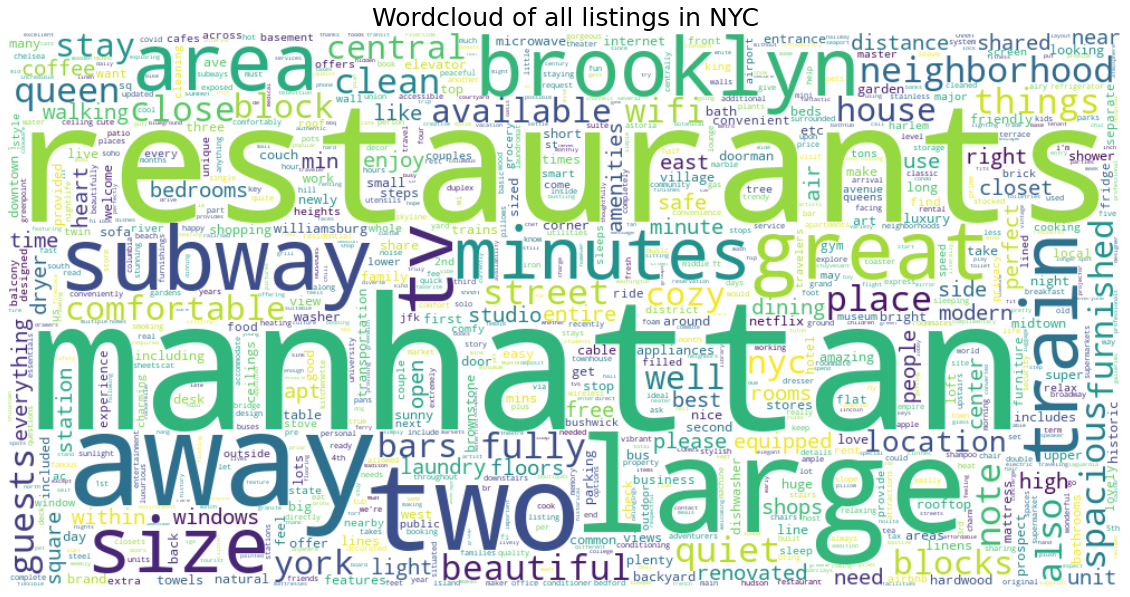

In [264]:
wc_airbnb_all = generate_word_cloud(stop_words,descriptions)
plot_word_cloud(wc_airbnb_all,'Wordcloud of all listings in NYC')


Let us now plot one wordcloud for each borough of NYC

In [265]:
bor_descr = df.loc[:,['description','neighbourhood_group_cleansed']].groupby('neighbourhood_group_cleansed')

In [269]:
boroughs = df.neighbourhood_group_cleansed.unique()
wc_bors = {}
for bor in boroughs:
    descriptions = ''.join(bor_descr.get_group(bor).description).lower()
    wc_bors[bor] = generate_word_cloud(stop_words,descriptions)    

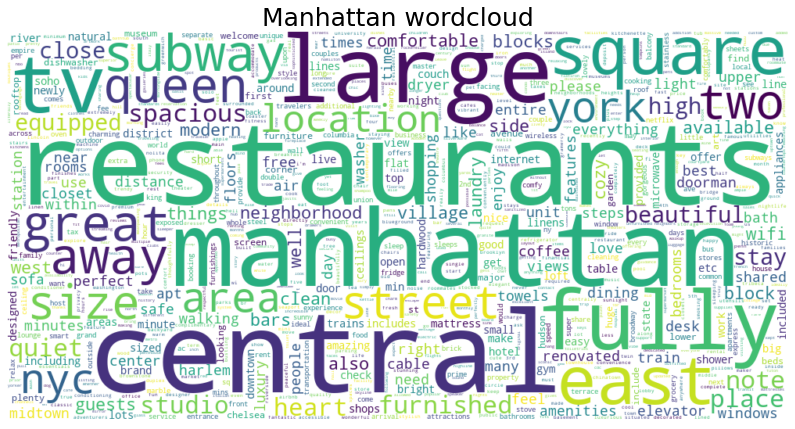

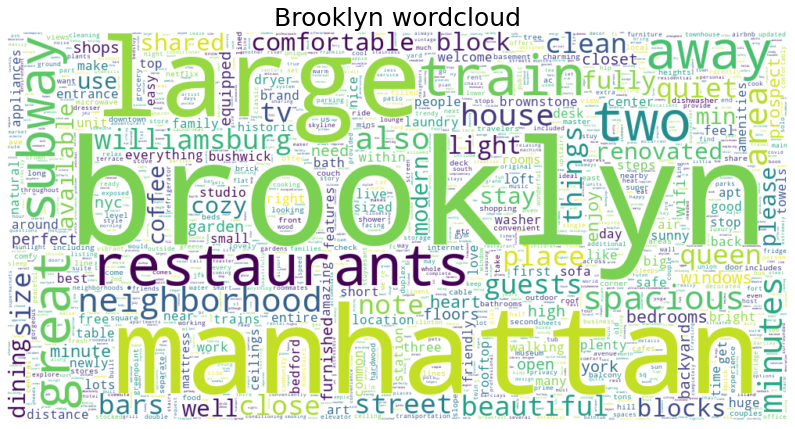

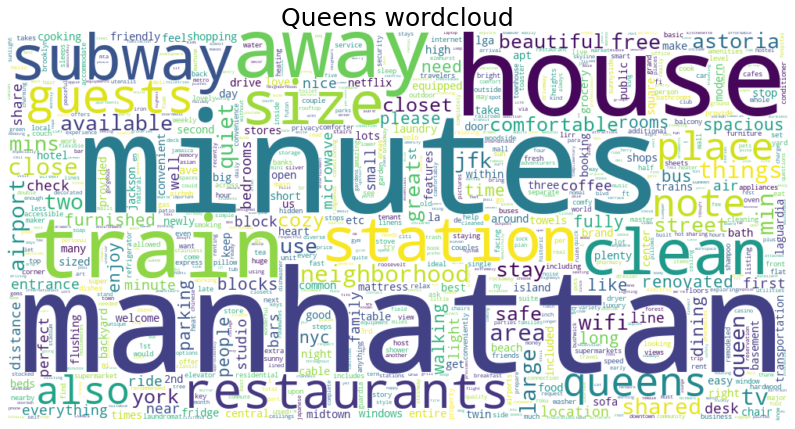

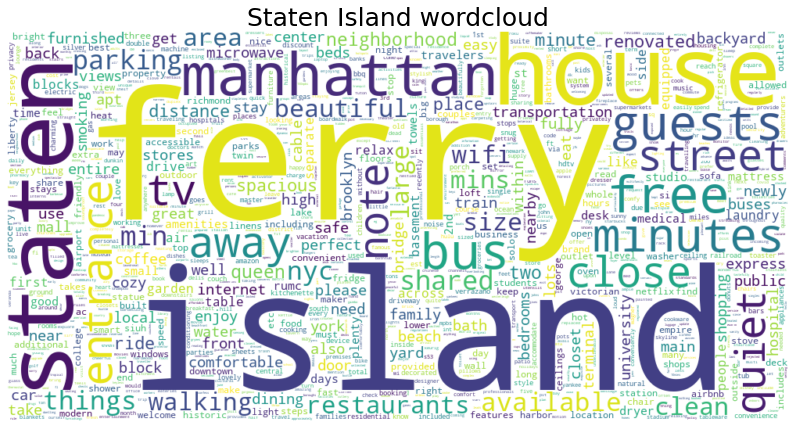

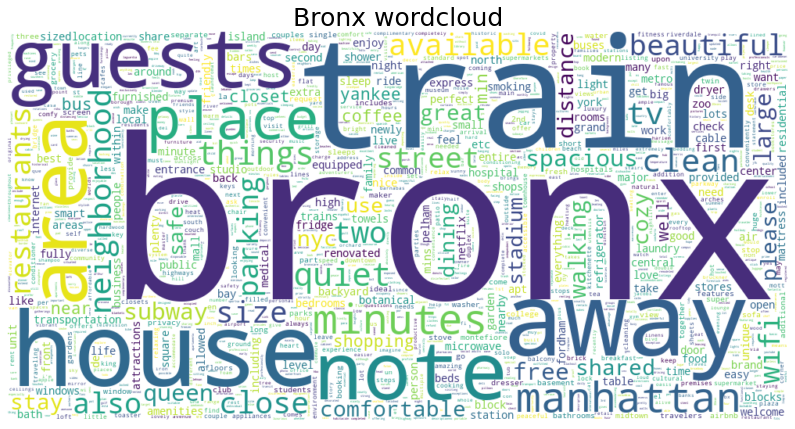

In [270]:
for bor in boroughs:
    plot_word_cloud(wc_bors[bor], bor + ' wordcloud', (14,6))

In [272]:
wc_bors['Manhattan'].words_

{'restaurants': 1.0,
 'central': 0.9624378567482968,
 'manhattan': 0.9438409132756398,
 'large': 0.92911066102007,
 'fully': 0.9125391272325538,
 'tv': 0.8976247468237893,
 'square': 0.8965199779046216,
 'east': 0.8869453139385012,
 'subway': 0.8758976247468238,
 'great': 0.8615356287976431,
 'away': 0.8477260173080464,
 'two': 0.8184496409501013,
 'queen': 0.8029828760817529,
 'size': 0.7788620880132572,
 'street': 0.7777573190940895,
 'york': 0.7488491990425336,
 'nyc': 0.7291474866507089,
 'area': 0.7238077702080649,
 'location': 0.7228871294420917,
 'spacious': 0.7076044927269379,
 'furnished': 0.7064997238077703,
 'quiet': 0.6976615724544283,
 'note': 0.6954520346160928,
 'place': 0.6908488307862272,
 'studio': 0.6529184312281348,
 'heart': 0.6518136623089671,
 'equipped': 0.6383723071257595,
 'high': 0.633769103295894,
 'stay': 0.6280611305468606,
 'beautiful': 0.6206960044190757,
 'close': 0.6159086724360154,
 'neighborhood': 0.6094641870742037,
 'guests': 0.6043085987847542,
 '

In [275]:
words = ['cozy', 'luxurious', 'manhattan','attractions','ferry','safe','quiet']
for word in words:
    print('Word: ' + word)
    for bor in boroughs:
        try:
            print(bor,wc_bors[bor].words_[word])
        except:
            print('The word ' + word + ' is not used in the description for listings in ' + bor)
    avg_word_price = df[df.description.str.find(word) != -1].price.mean()
    print('Average price when this word appears in the description: ' + str(avg_word_price))
    print('\n')

Word: cozy
Manhattan 0.48002209537838336
Brooklyn 0.2687281795511222
Queens 0.3742810188989318
Staten Island 0.19140625
Bronx 0.3333333333333333
Average price when this word appears in the description: 116.76422250316055


Word: luxurious
Manhattan 0.09777204934634505
Brooklyn 0.01915211970074813
Queens 0.020542317173377157
Staten Island 0.01171875
Bronx 0.025193798449612403
Average price when this word appears in the description: 221.64310954063603


Word: manhattan
Manhattan 0.9438409132756398
Brooklyn 0.6608478802992519
Queens 1.0
Staten Island 0.734375
Bronx 0.5930232558139535
Average price when this word appears in the description: 115.26483050847457


Word: attractions
Manhattan 0.16148039035168477
Brooklyn 0.023042394014962594
Queens 0.029170090386195564
Staten Island 0.01953125
Bronx 0.13178294573643412
Average price when this word appears in the description: 156.8523316062176


Word: ferry
Manhattan 0.0149143804087645
Brooklyn 0.026134663341645884
Queens 0.02218570254724733
St

In [256]:
df[df.description.str.find('ferry') != -1].price.mean()

134.52805280528054

In [221]:
wc_bors['Brooklyn'].words_['cozy']

0.2687281795511222

## Plot information on choropleth maps

### Choropleth maps of the listings

#### Choropleth map of the average price per neighborhood

In [619]:
nycmap = folium.Map(location=[df.latitude.mean(),df.longitude.mean()],zoom_start=10)
nycmap

In [620]:
neighb_prices = df.loc[:,['price','neighbourhood_cleansed']].groupby('neighbourhood_cleansed',as_index=False).mean()

In [621]:
nycmap = folium.Map(location=[df.latitude.mean(),df.longitude.mean()],zoom_start=10)
nycmap.choropleth(geo_data='map/neighbourhoods_nyc.geojson',
                  data = neighb_prices,
                  columns=['neighbourhood_cleansed','price'],
                  fill_color='RdPu',
                  key_on='feature.properties.neighbourhood',
                  fill_opacity=0.6, 
                  line_opacity=0.8,
                  legend_name='Average price'
                 )

nycmap

From the choropleth map it is difficult to distinguish the differences between neighborhoods due to a single neighborhood having a much larger average price than the rest. Let's find it and see if it is worth it to keep it in the map

In [420]:
neighb_prices[neighb_prices.price == neighb_prices.price.max()]

neighbourhood_cleansed  price
81         Fort Wadsworth  800.0

In [448]:
neighb_prices

neighbourhood_cleansed       price
0                 Allerton   98.393939
1            Arden Heights  173.666667
2                 Arrochar  107.937500
3                  Arverne  205.043478
4                  Astoria   87.792366
..                     ...         ...
215            Willowbrook  309.000000
216        Windsor Terrace  125.447917
217              Woodhaven   72.219178
218               Woodlawn  108.250000
219               Woodside   53.038462

[220 rows x 2 columns]

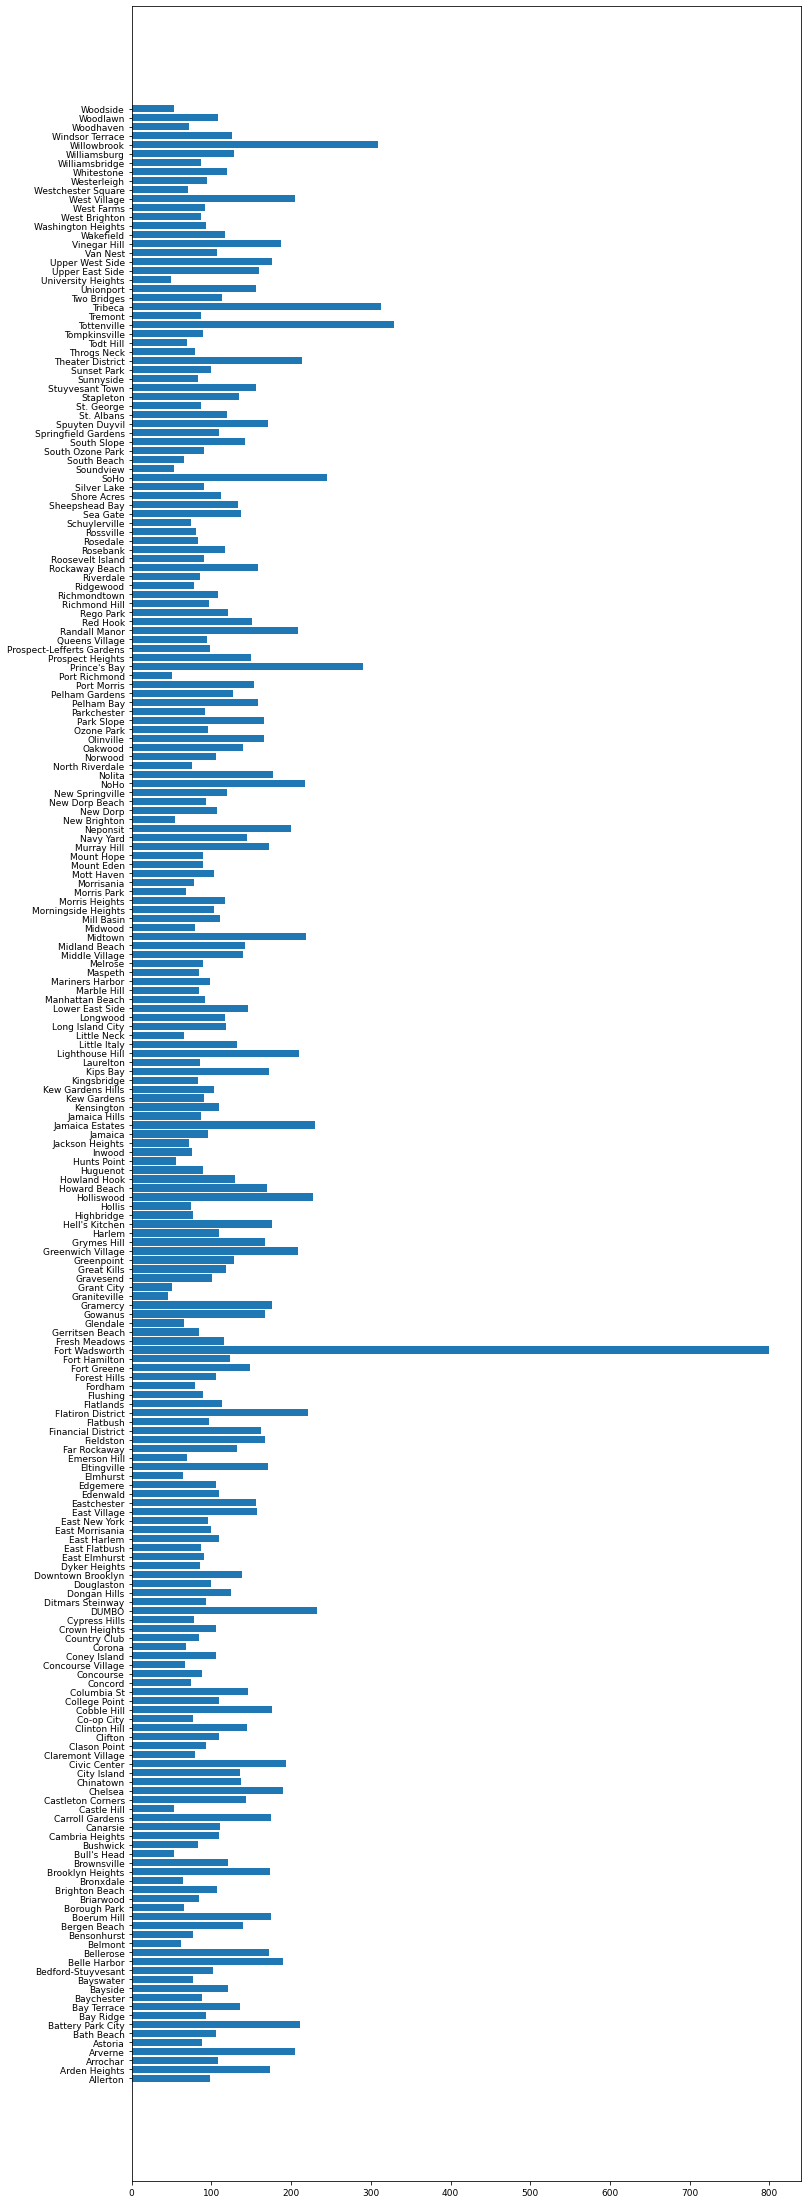

In [452]:
plt.barh(neighb_prices['neighbourhood_cleansed'],neighb_prices['price'])
plt.rcParams['figure.figsize']=(12,40)
plt.tick_params(labelsize=9)
plt.show()

In [453]:
df.neighbourhood_cleansed[df.neighbourhood_cleansed == 'Fort Wadsworth'].count()

1

We find that "Fort Wadsworth" is the neighborhood that contains the maximum price and from the bar plot we see that its value is much higher than the rest. We also notice that there is only one listing in that neighborhood. So it might make more sense to drop this value from the dataframe. We will do so and then replot the map

In [472]:
neighb_prices = neighb_prices[neighb_prices.neighbourhood_cleansed != 'Fort Wadsworth']

In [484]:
nycmap = folium.Map(location=[df.latitude.mean(),df.longitude.mean()],zoom_start=10)
nycmap.choropleth(geo_data='map/neighbourhoods_nyc.geojson',
                  data = neighb_prices,
                  columns=['neighbourhood_cleansed','price'],
                  fill_color='RdPu',
                  key_on='feature.properties.neighbourhood',
                  fill_opacity=0.85, 
                  line_opacity=0.8,
                  legend_name='Average price'
                 )

nycmap

From the map, we confirm something we already knew: in general, the average price in Manhattan is higher than for the other boroughs. It seems that the lower west side of Manhattan is more expensive than the rest of the borough, with Tribeca being the most expensive neighborhood in Manhattan.

We also notice that some neighborhoods in Staten Island seem to be among the most expensive ones. Once again, these could be outliers, or single listings as it was the case for the "Fort Wadsworth" neighboorhood. Let's check that

In [503]:
staten_island_counts = df[df.neighbourhood_group_cleansed == 'Staten Island'].groupby('neighbourhood_cleansed').count()['price']
staten_island_counts

neighbourhood_cleansed
Arden Heights         3
Arrochar             16
Bull's Head           2
Castleton Corners     5
Clifton               9
Concord              17
Dongan Hills          3
Eltingville           3
Emerson Hill          5
Fort Wadsworth        1
Graniteville          1
Grant City           11
Great Kills           4
Grymes Hill           6
Howland Hook          3
Huguenot              3
Lighthouse Hill       1
Mariners Harbor      11
Midland Beach         6
New Brighton          6
New Dorp              2
New Dorp Beach        3
New Springville       4
Oakwood               4
Port Richmond         7
Prince's Bay          3
Randall Manor        11
Richmondtown          3
Rosebank              3
Rossville             2
Shore Acres          10
Silver Lake           3
South Beach           2
St. George           41
Stapleton            14
Todt Hill             1
Tompkinsville        40
Tottenville           1
West Brighton        20
Westerleigh           1
Willowbrook      

In [566]:
staten_island_onelisting = staten_island_counts[staten_island_counts == 1]
staten_island_onelisting = staten_island_onelisting[staten_island_onelisting.index != 'Fort Wadsworth']
tmp = neighb_prices.set_index('neighbourhood_cleansed')
tmp.loc[staten_island_onelisting.index]

price
neighbourhood_cleansed       
Graniteville             45.0
Lighthouse Hill         210.0
Todt Hill                69.0
Tottenville             329.0
Westerleigh              94.0
Willowbrook             309.0

In [565]:
neighb_prices[neighb_prices.neighbourhood_cleansed == 'Tribeca']

neighbourhood_cleansed       price
197                Tribeca  312.918239

We indeed confirm that for some neighborhoods of Staten Island there is only one listing and the average price is high. However, this does not 'bother' us with respect to the choropleth map, because these high prices are similar to the highest price in Tribeca (shown in the previous cell)

#### Choropleth map of the total amount of listings per neighborhood

Let us now plot another choropleth map, but this time based on the amount of listings per neighborhood. This will complement the information we found about Staten Island in the previous section

In [617]:
neighb_listings = df.loc[:,['price','neighbourhood_cleansed']].groupby('neighbourhood_cleansed',as_index=False).count()
neighb_listings.rename(columns={'price': 'amount'},inplace = True)

In [618]:
nycmap = folium.Map(location=[df.latitude.mean(),df.longitude.mean()],zoom_start=10)
fig = nycmap.choropleth(geo_data='map/neighbourhoods_nyc.geojson',
                  data = neighb_listings,
                  columns=['neighbourhood_cleansed','amount'],
                  fill_color='RdPu',
                  key_on='feature.properties.neighbourhood',
                  fill_opacity=0.85, 
                  line_opacity=0.8,
                  legend_name='Amount of listings'
                 )

nycmap

Except for few darker neighborhoods, the rest of the map looks quite uniform. Let's accentuate the difference by using a logarithmic value instead

In [624]:
neighb_listings.loc[:,'amount_log'] = neighb_listings.amount.apply(np.log10)


# Get the maximum value to cap displayed values
max_log = neighb_listings['amount_log'].max()
max_val = int(max_log) + 1

# Prepare the range of the colorbar
values = [i for i in range(max_val)]
ticks = [10**i for i in values]

In [637]:
nycmap = folium.Map(location=[df.latitude.mean(),df.longitude.mean()],zoom_start=10)
fig = nycmap.choropleth(geo_data='map/neighbourhoods_nyc.geojson',
                  data = neighb_listings,
                  columns=['neighbourhood_cleansed','amount_log'],
                  fill_color='RdPu',
                  key_on='feature.properties.neighbourhood',
                  fill_opacity=0.85, 
                  line_opacity=0.8,
                  legend_name='Amount of listings',
                 )

nycmap

The legend in the above plot is now in log10 scale and we can appreciate the differences much more.

We can confirm indeed that Staten Island is the borough with the lowest amount of listings, especially on the west side of the island, which is farther from the Ferry and hence from touristic attractions of Manhattan. We also notice that the neighborhoods with more listings are in Manhattan, Brooklyn, and Queens. Between these three boroughs, it is actually Manhattan and Brooklyn that have the neighborhood with more listings.

In [638]:
df['cozy' in df.description.str]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [650]:
## instantiate a feature group for the incidents in the dataframe
#maplistings = folium.map.FeatureGroup()
#
## loop through the 100 crimes and add each to the incidents feature group
#for lat, lng, in zip(df.latitude, df.longitude):
#    maplistings.add_child(
#        folium.features.CircleMarker(
#            [lat, lng],
#            radius=2, # define how big you want the circle markers to be
#            color='red',
#            fill=True,
#            fill_color='blue',
#            fill_opacity=0.6
#        )
#    )
#
## add incidents to map
#nycmap.add_child(maplistings)